In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mlflow
import mlflow.statsmodels
from mlflow.models import infer_signature

from utils import pretty_adf, pretty_coint, pretty_kpss

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (16, 9)

In [3]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

In [3]:
mlflow.set_tracking_uri("http://localhost:5000")

In [4]:
mlflow.set_experiment("/check-localhost-connection")

<Experiment: artifact_location='mlflow-artifacts:/227842250200065244', creation_time=1708903675942, experiment_id='227842250200065244', last_update_time=1708903675942, lifecycle_stage='active', name='/check-localhost-connection', tags={}>

In [5]:
mlflow.statsmodels.autolog()

In [4]:
def data_sim(n_obs, beta=1, alpha=.15, ly=.05, lx=.01, x_eq=2, n_spurious=1, start='2020-01-01', sigma_shocks=.1, drift_x=0, frac_noise=0.3):
  x_causal = [-5]
  y = [10]

  for i in range(n_obs-1):
    dx = np.random.normal(0, sigma_shocks) + drift_x
    
    dy = ly*dx - alpha*(y[i] - beta*x_causal[i]) + frac_noise*np.random.normal(0, 1)
    
    x_new = x_eq  + (1 - lx)*(x_causal[i] - x_eq)  + dx
    x_causal.append(x_new)
    y_new =  y[i] + dy
    y.append(y_new)
  return pd.DataFrame({'x_causal': x_causal, 'y': y} | {f'x_spurious_{i}': np.random.normal(0, sigma_shocks, n_obs).cumsum() for i in range(n_spurious)}, index=pd.date_range(start, periods=n_obs, freq='W-MON'))

In [9]:
def dgp(beta, rho, sigma_x=0, sigma_z=0, theta=0, T=156, n_spurious=0, rho_x=1):
  e_zt, e_xt = np.random.multivariate_normal([0, 0], [[sigma_z**2, theta*sigma_x*sigma_z], [theta*sigma_z*sigma_x, sigma_x**2]], T).T
  zt = np.zeros(T)
  xt = np.zeros(T)
  yt = np.zeros(T)
  spurious = np.random.normal(0, sigma_x**2, (T, n_spurious)).cumsum(axis=0) if n_spurious > 0 else np.zeros((T, 0))
  zt[0] = np.random.normal(0, sigma_z)
  yt[0] = np.random.normal(0, sigma_z)
  xt[0] = np.random.normal(0, sigma_x)
  for t in range(1, T):
    zt[t] = rho*zt[t-1] + e_zt[t]
    xt[t] = rho_x*xt[t-1] + e_xt[t]
    yt[t] = beta*xt[t] + zt[t]
  data = pd.DataFrame({'y': yt, 'x_causal': xt} | {f'x_spurious_{i}': spurious[:, i] for i in range(n_spurious)}, index=pd.date_range('2020-01-01', periods=T, freq='W-MON'))
  return data

Text(0.5, 1.0, 'Simulated data')

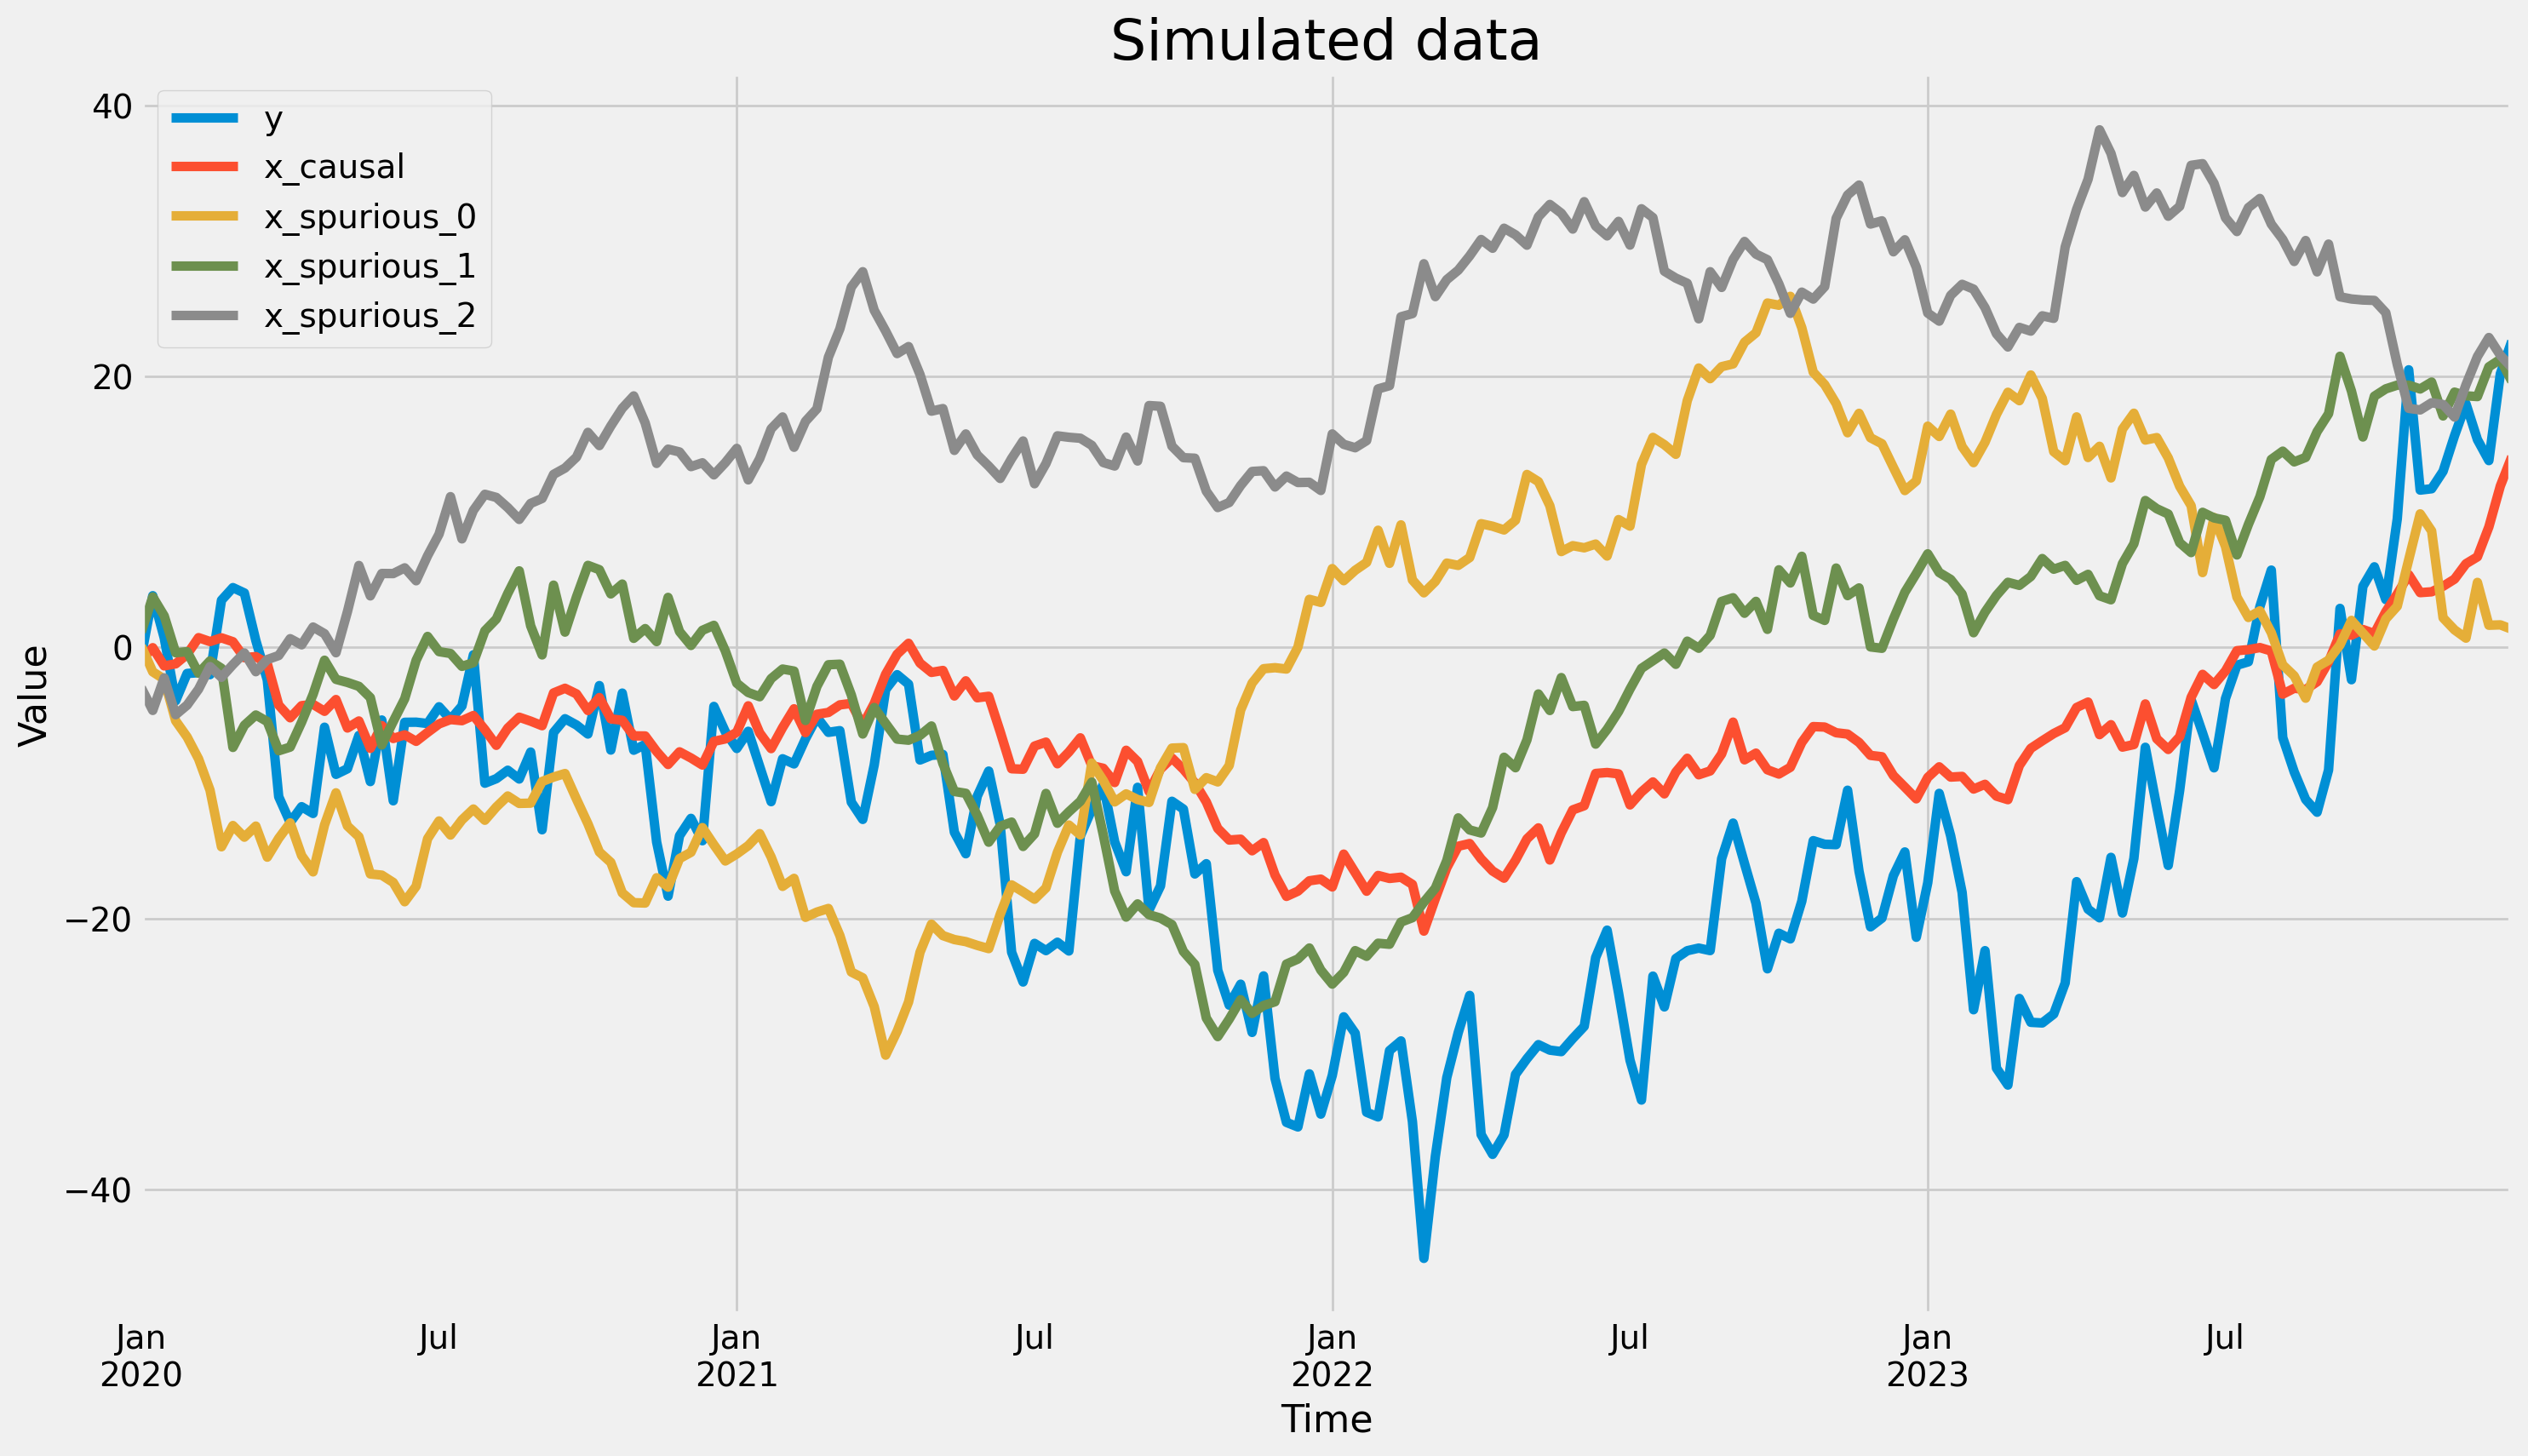

In [37]:
#data = pd.read_csv('simulated_data.csv', index_col=0) 
#data = data_sim(208, beta=1.7, ly=1, alpha=0.2, lx=0, x_eq=15, n_spurious=3, sigma_shocks=3, drift_x=0, frac_noise=1)
#data.index = pd.to_datetime(data.index)
data = dgp(2, 0.75, sigma_x=1.4, sigma_z=3, theta=0.02, T=208, n_spurious=3, rho_x=1)
data.plot()
plt.xlabel('Time', fontdict={'fontsize': 16})
plt.ylabel('Value', fontdict={'fontsize': 16})
plt.title('Simulated data', fontdict={'fontsize': 24})

In [38]:
#data.to_csv('simulated_data.csv')

In [39]:
mlflow_context = mlflow.start_run()

In [40]:
split = 0.75
split_index = int(len(data)*split)
train = data.iloc[:split_index]
test = data.iloc[split_index:]

In [41]:
training = mlflow.data.from_pandas(train, 'train')

/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:143: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]


In [42]:
ols_diff_model = sm.OLS(train['y'].diff(1).dropna(), sm.add_constant(train[['x_causal']].diff(1).dropna())).fit()
ols_diff_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     93.73
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           1.37e-17
Time:                        19:15:35   Log-Likelihood:                -398.73
No. Observations:                 155   AIC:                             801.5
Df Residuals:                     153   BIC:                             807.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0069      0.257     -0.027      0.978      -0.514       0.500
x_causal       1.9223      0.199      9.682      0.000       1.530       2.315
==============================================================================
Omnibus:                        0.772   Durbin-Watson:                   2.494
Prob(Omnibus):                  0.680   Jarque-Bera (JB):                0.873
Skew:                           0.157   Prob(JB):                        0.646
Kurtosis:                       2.809   Cond. No.                         1.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
ols_model = sm.OLS(train['y'], (train[['x_causal']])).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              2945.
Date:                Sun, 03 Mar 2024   Prob (F-statistic):                   9.76e-103
Time:                        19:15:36   Log-Likelihood:                         -447.16
No. Observations:                 156   AIC:                                      896.3
Df Residuals:                     155   BIC:                                      899.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x_causal       1.9598      0.036     54.266      0.000       1.888       2.031
==============================================================================
Omnibus:                        2.892   Durbin-Watson:                   0.552
Prob(Omnibus):                  0.236   Jarque-Bera (JB):                2.427
Skew:                          -0.192   Prob(JB):                        0.297
Kurtosis:                       2.525   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
ols_model_sp = sm.OLS(train['y'], sm.add_constant(train[['x_spurious_0']])).fit()
ols_model_sp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     79.53
Date:                Sun, 03 Mar 2024   Prob (F-statistic):           1.30e-15
Time:                        19:16:27   Log-Likelihood:                -558.73
No. Observations:                 156   AIC:                             1121.
Df Residuals:                     154   BIC:                             1128.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.8651      0.741    -24.114      0.000     -19.329     -16.402
x_spurious_0    -0.4441      0.050     -8.918      0.000      -0.542      -0.346
==============================================================================
Omnibus:                        1.979   Durbin-Watson:                   0.215
Prob(Omnibus):                  0.372   Jarque-Bera (JB):                1.914
Skew:                          -0.194   Prob(JB):                        0.384
Kurtosis:                       2.621   Cond. No.                         15.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
with mlflow_context:
  mlflow.log_input(training, context='train')
  ols_diff_model = sm.OLS(train['y'].diff(1).dropna(), sm.add_constant(train[['x_causal']].diff(1).dropna())).fit()
  ols_diff_model.summary()

In [101]:
with mlflow_context:
  mlflow.log_input(training, context='train')
  ols_model = sm.OLS(train['y'], (train[['x_causal']])).fit()
  ols_model.summary()

2024/02/28 15:19:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils."
2024/02/28 15:19:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [102]:
with mlflow_context:
  mlflow.log_input(training, context='train')
  ols_model_sp = sm.OLS(train['y'], sm.add_constant(train[['x_spurious_1']])).fit()
  ols_model_sp.summary()

2024/02/28 15:19:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils."
2024/02/28 15:19:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/mreda/opt/anaconda3/envs/pymc-python311/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


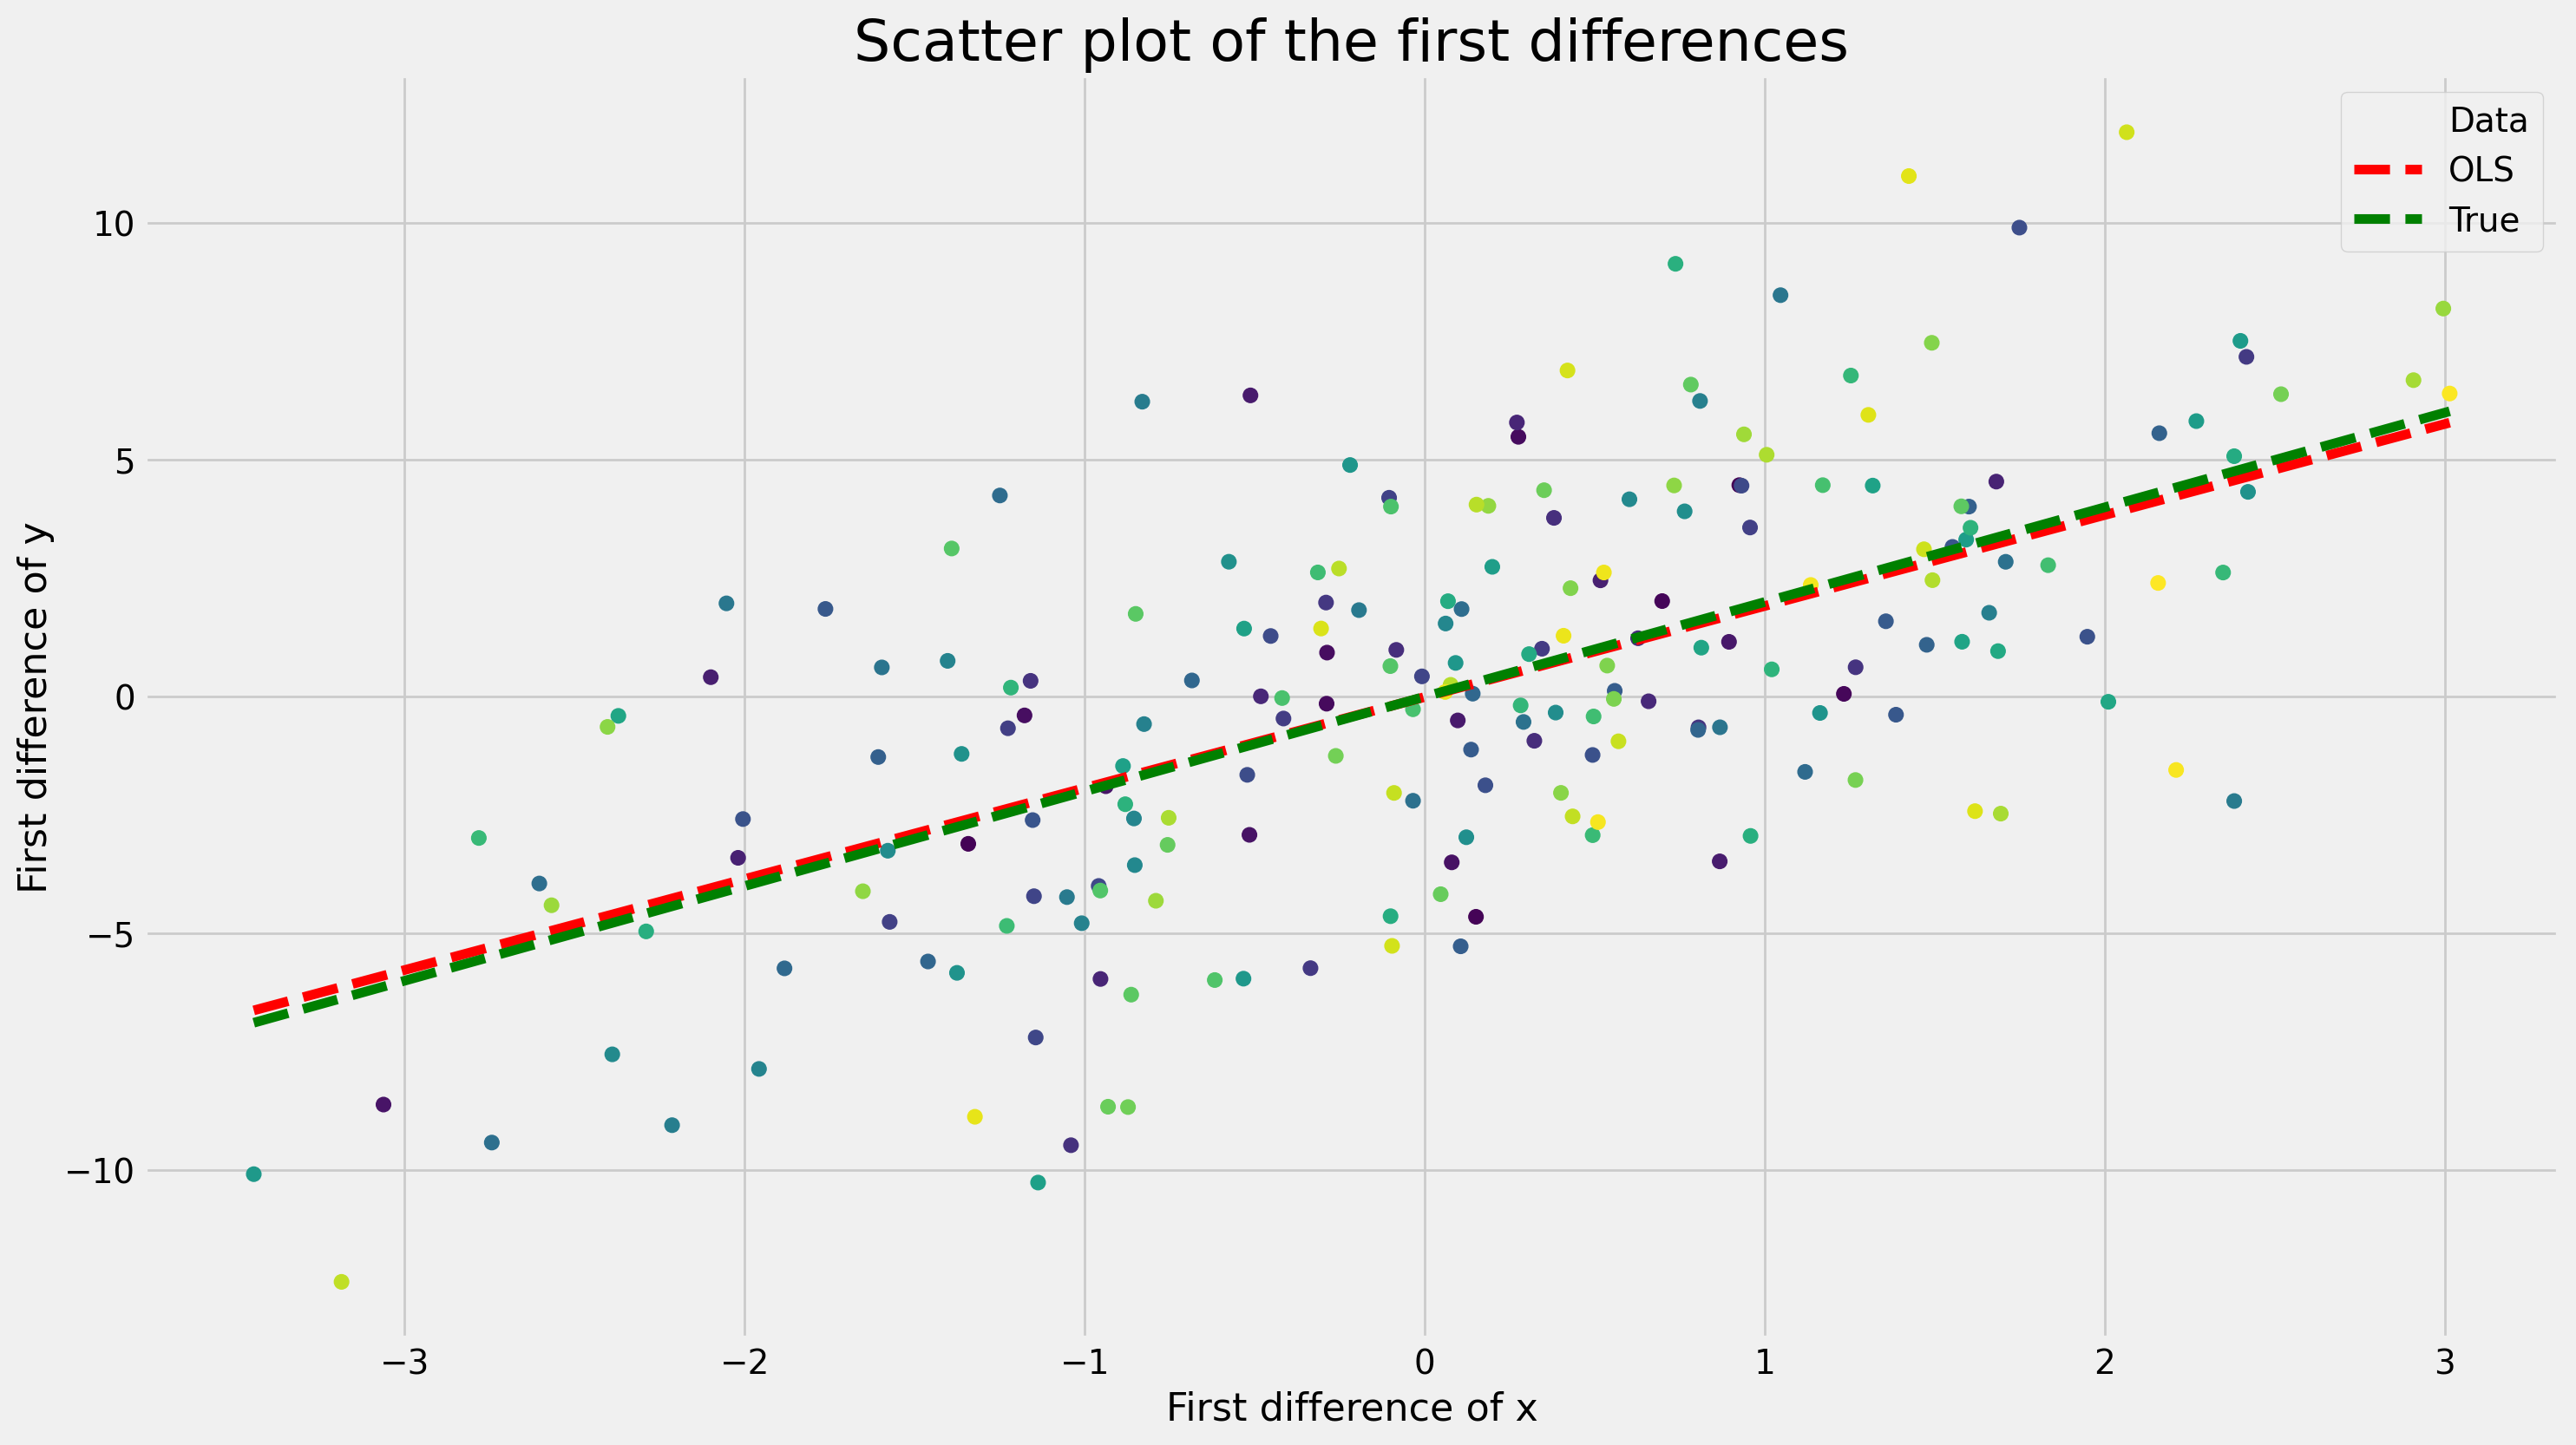

In [49]:
plt.scatter(data['x_causal'].diff(1), data['y'].diff(1), label='Data', c=data.index)
plt.title('Scatter plot of the first differences', fontdict={'fontsize': 24})
plt.xlabel('First difference of x', fontdict={'fontsize': 16})
plt.ylabel('First difference of y', fontdict={'fontsize': 16})
plt.plot(data[['x_causal']].diff().sort_values(by='x_causal').dropna(), 
         ols_diff_model.predict(
           sm.add_constant(
             data[['x_causal']].diff(1).sort_values('x_causal').dropna())),
         'r', ls='--', label='OLS')
plt.plot(data[['x_causal']].diff().sort_values(by='x_causal').dropna(),
          2*data[['x_causal']].diff().sort_values(by='x_causal').dropna(), 'g', ls='--', label='True')
plt.legend()
plt.show()



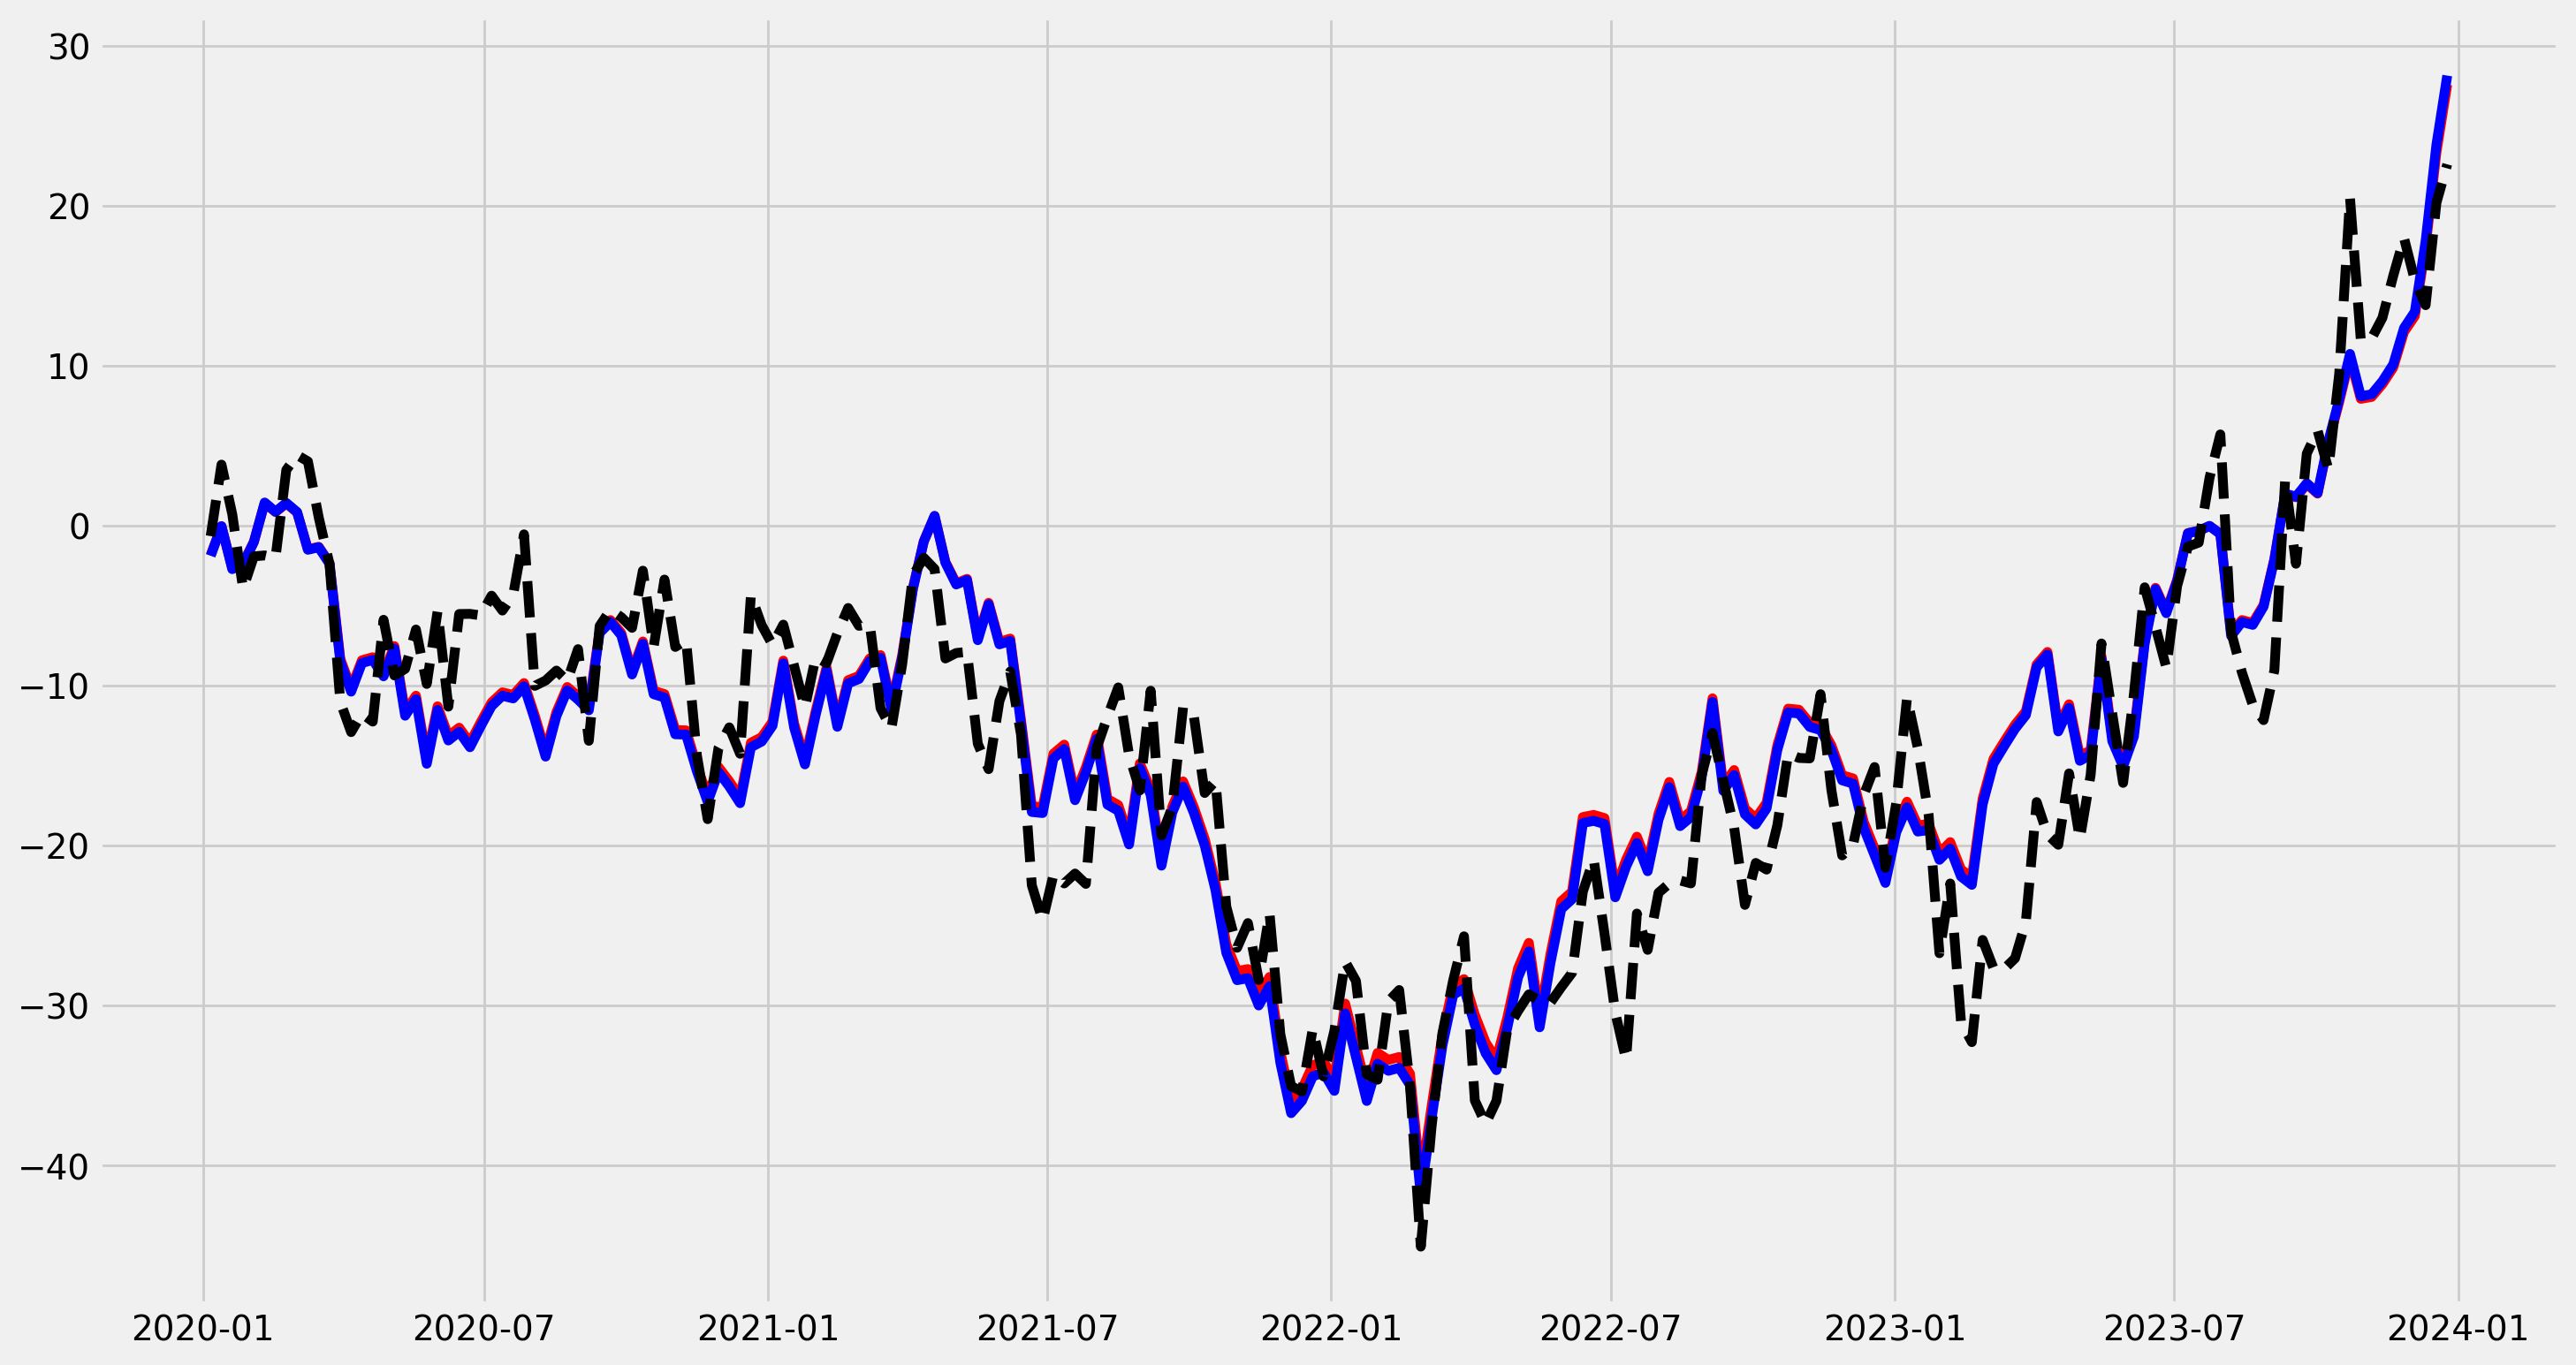

In [50]:
plt.plot(data.index, ols_model.predict((data[['x_causal']])),'r', label='OLS')
plt.plot(data.index, data['x_causal']*2, label='Long Run', c='b')
plt.plot(data.index, data['y'], label='Data', c='k', ls='--')

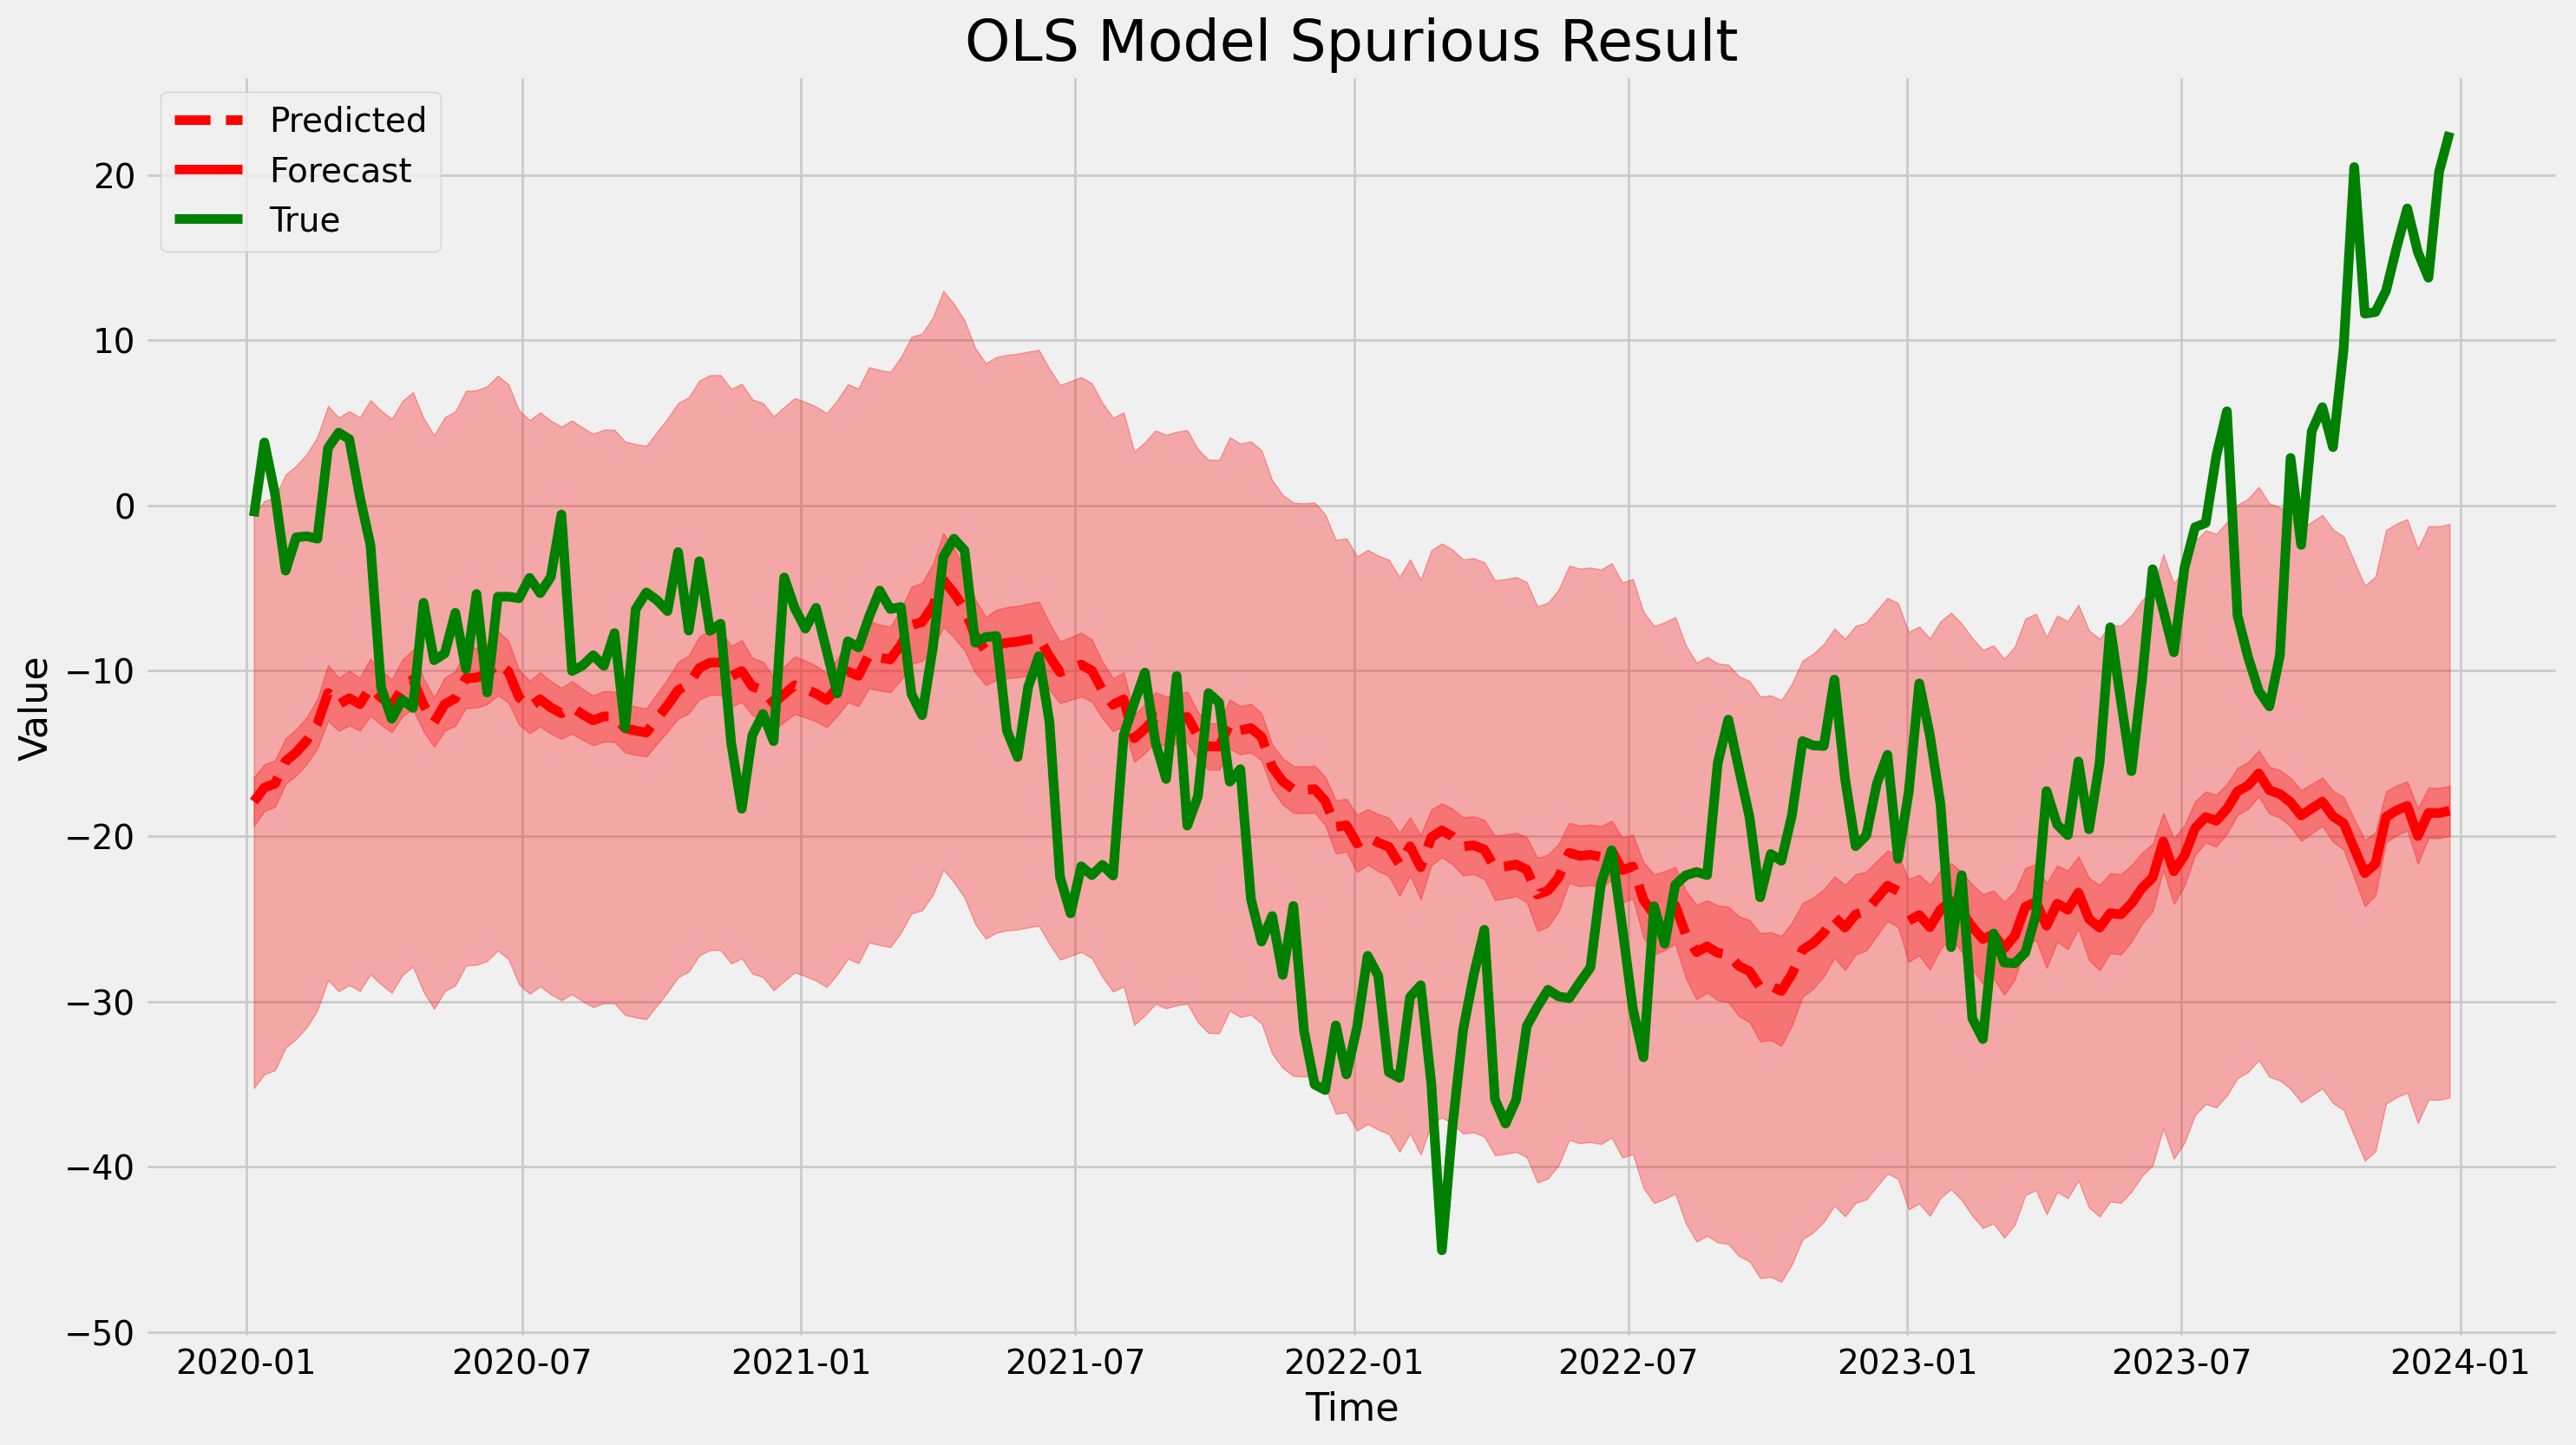

In [51]:
spurious_model_prediction = ols_model_sp.get_prediction(sm.add_constant(data[['x_spurious_0']])).summary_frame()

plt.plot(data.iloc[:split_index].index, spurious_model_prediction['mean'].iloc[:split_index], 'r', ls='--', label='Predicted')
plt.fill_between(data.index, spurious_model_prediction['obs_ci_lower'], spurious_model_prediction['obs_ci_upper'], color='r', alpha=0.3)
plt.fill_between(data.index, spurious_model_prediction['mean_ci_lower'], spurious_model_prediction['mean_ci_upper'], color='r', alpha=0.3)
plt.plot(data.iloc[split_index:].index, spurious_model_prediction['mean'].iloc[split_index:], label='Forecast', c='r')
plt.plot(data.index, data['y'], label='True', c='g')
plt.legend()
plt.title('OLS Model Spurious Result', fontdict={'fontsize': 24})
plt.xlabel('Time', fontdict={'fontsize': 16})
plt.ylabel('Value', fontdict={'fontsize': 16})
plt.show()

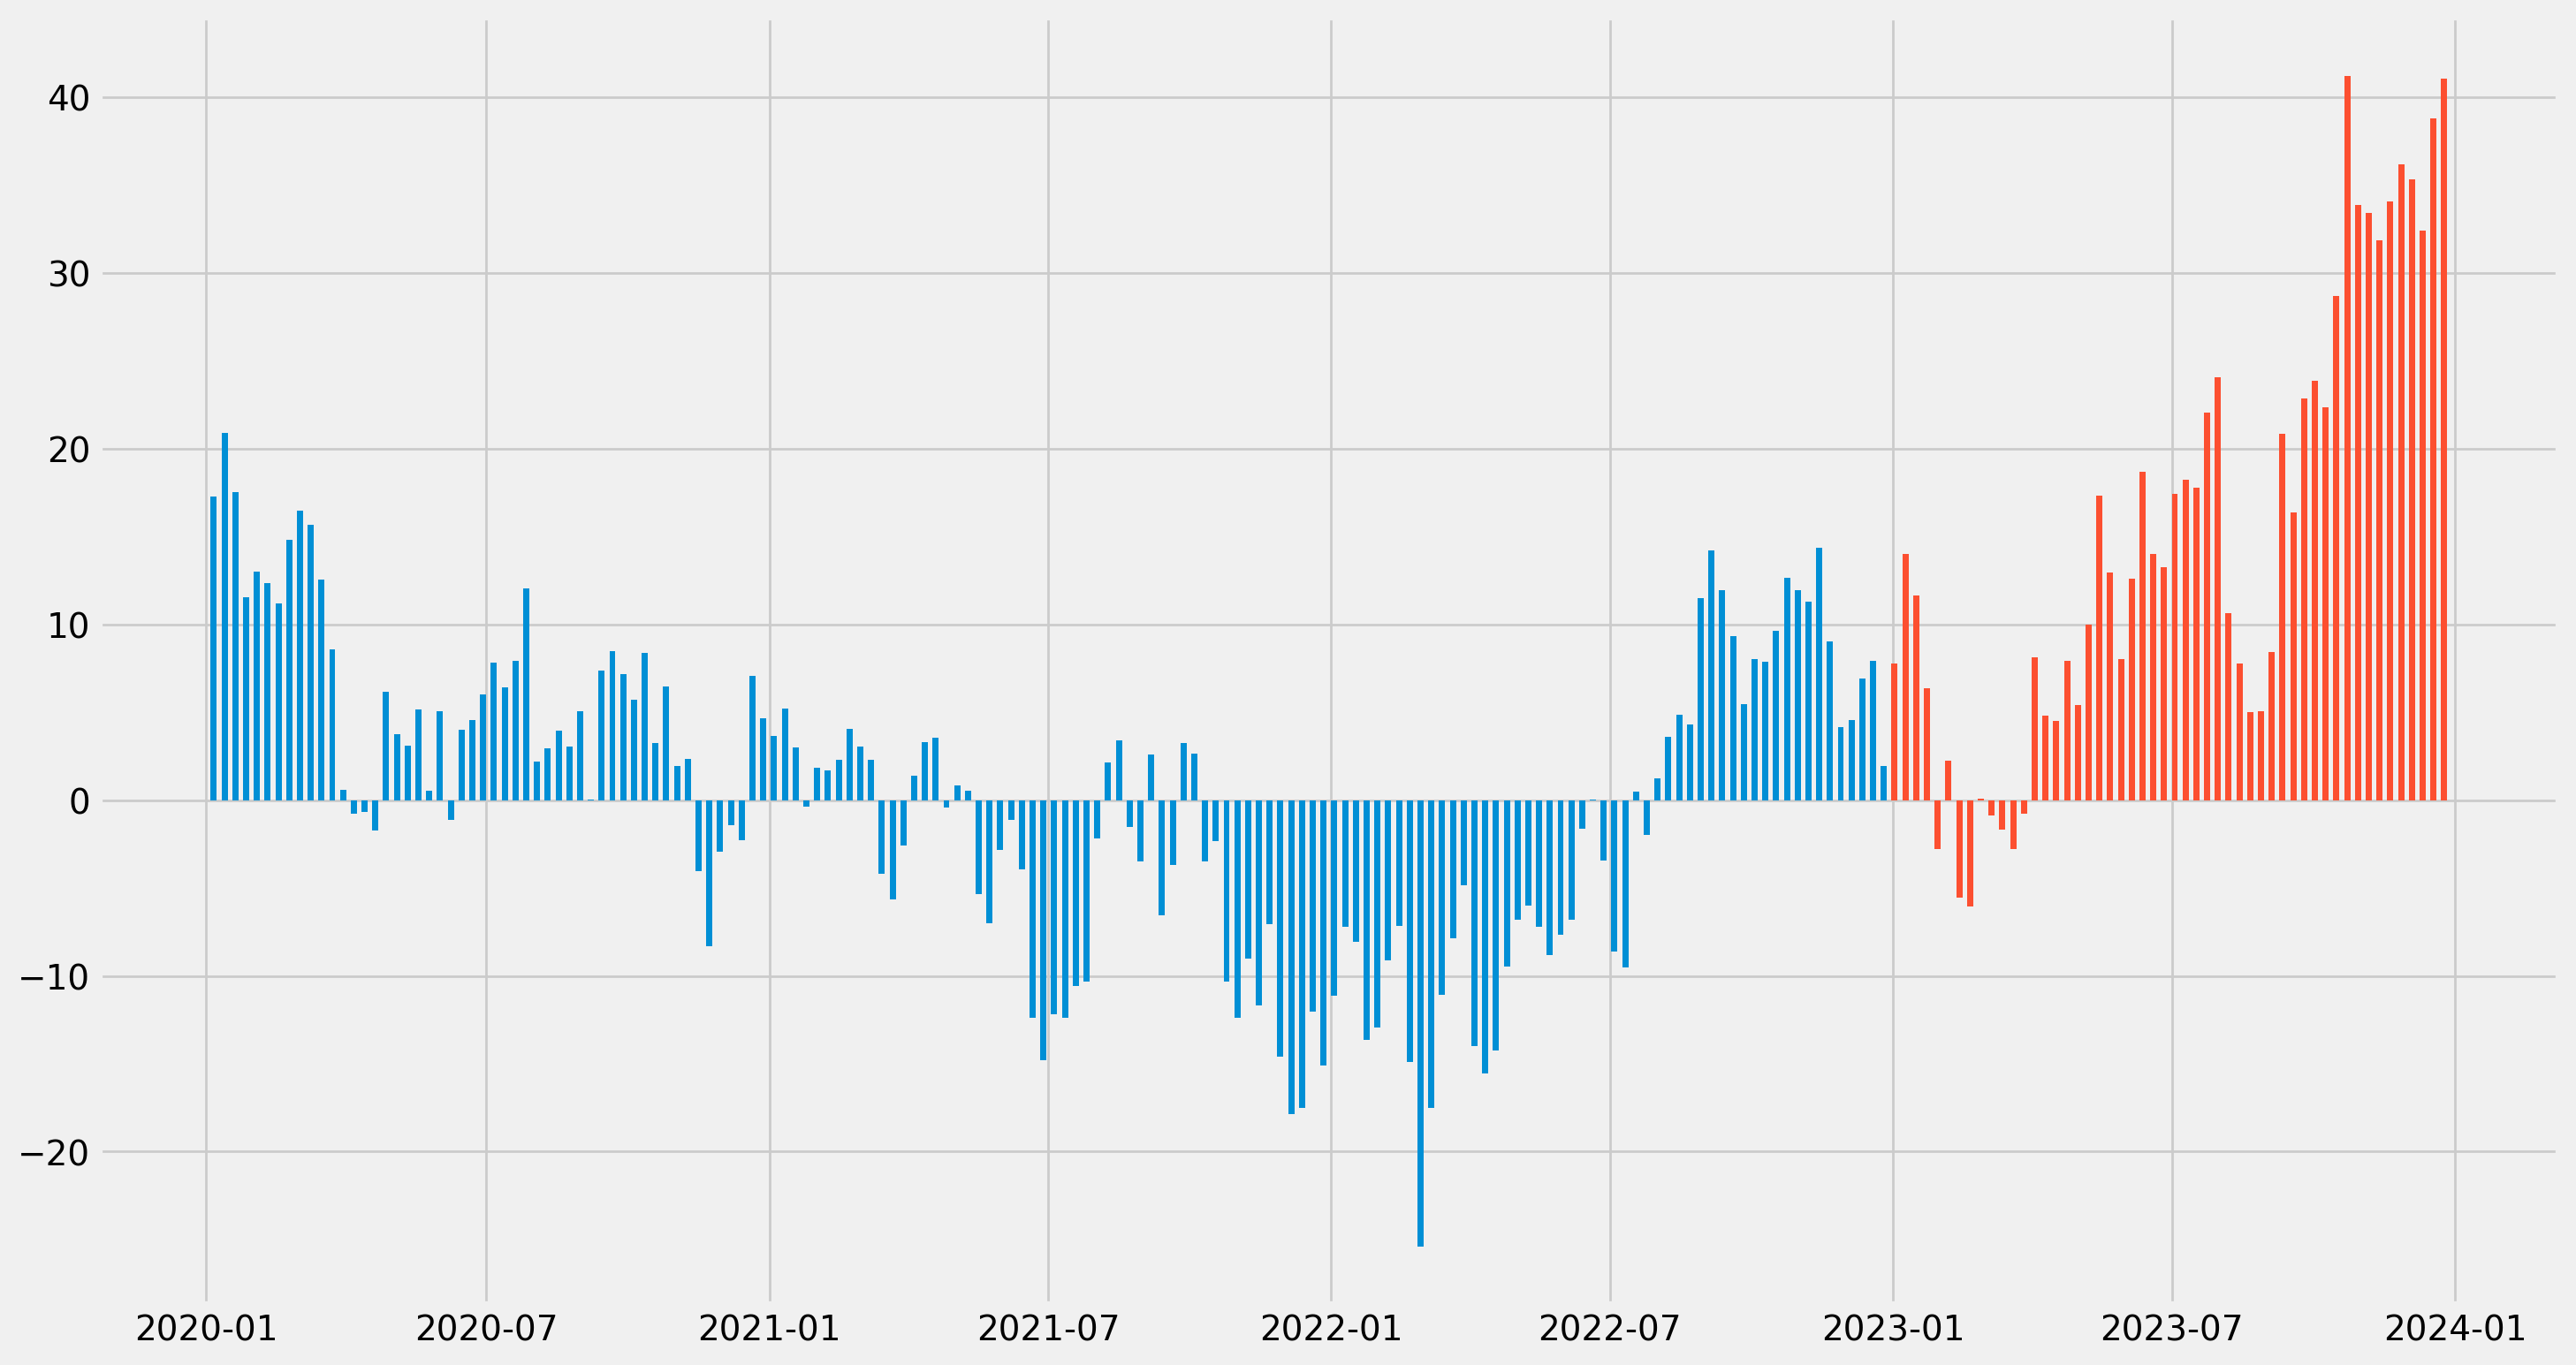

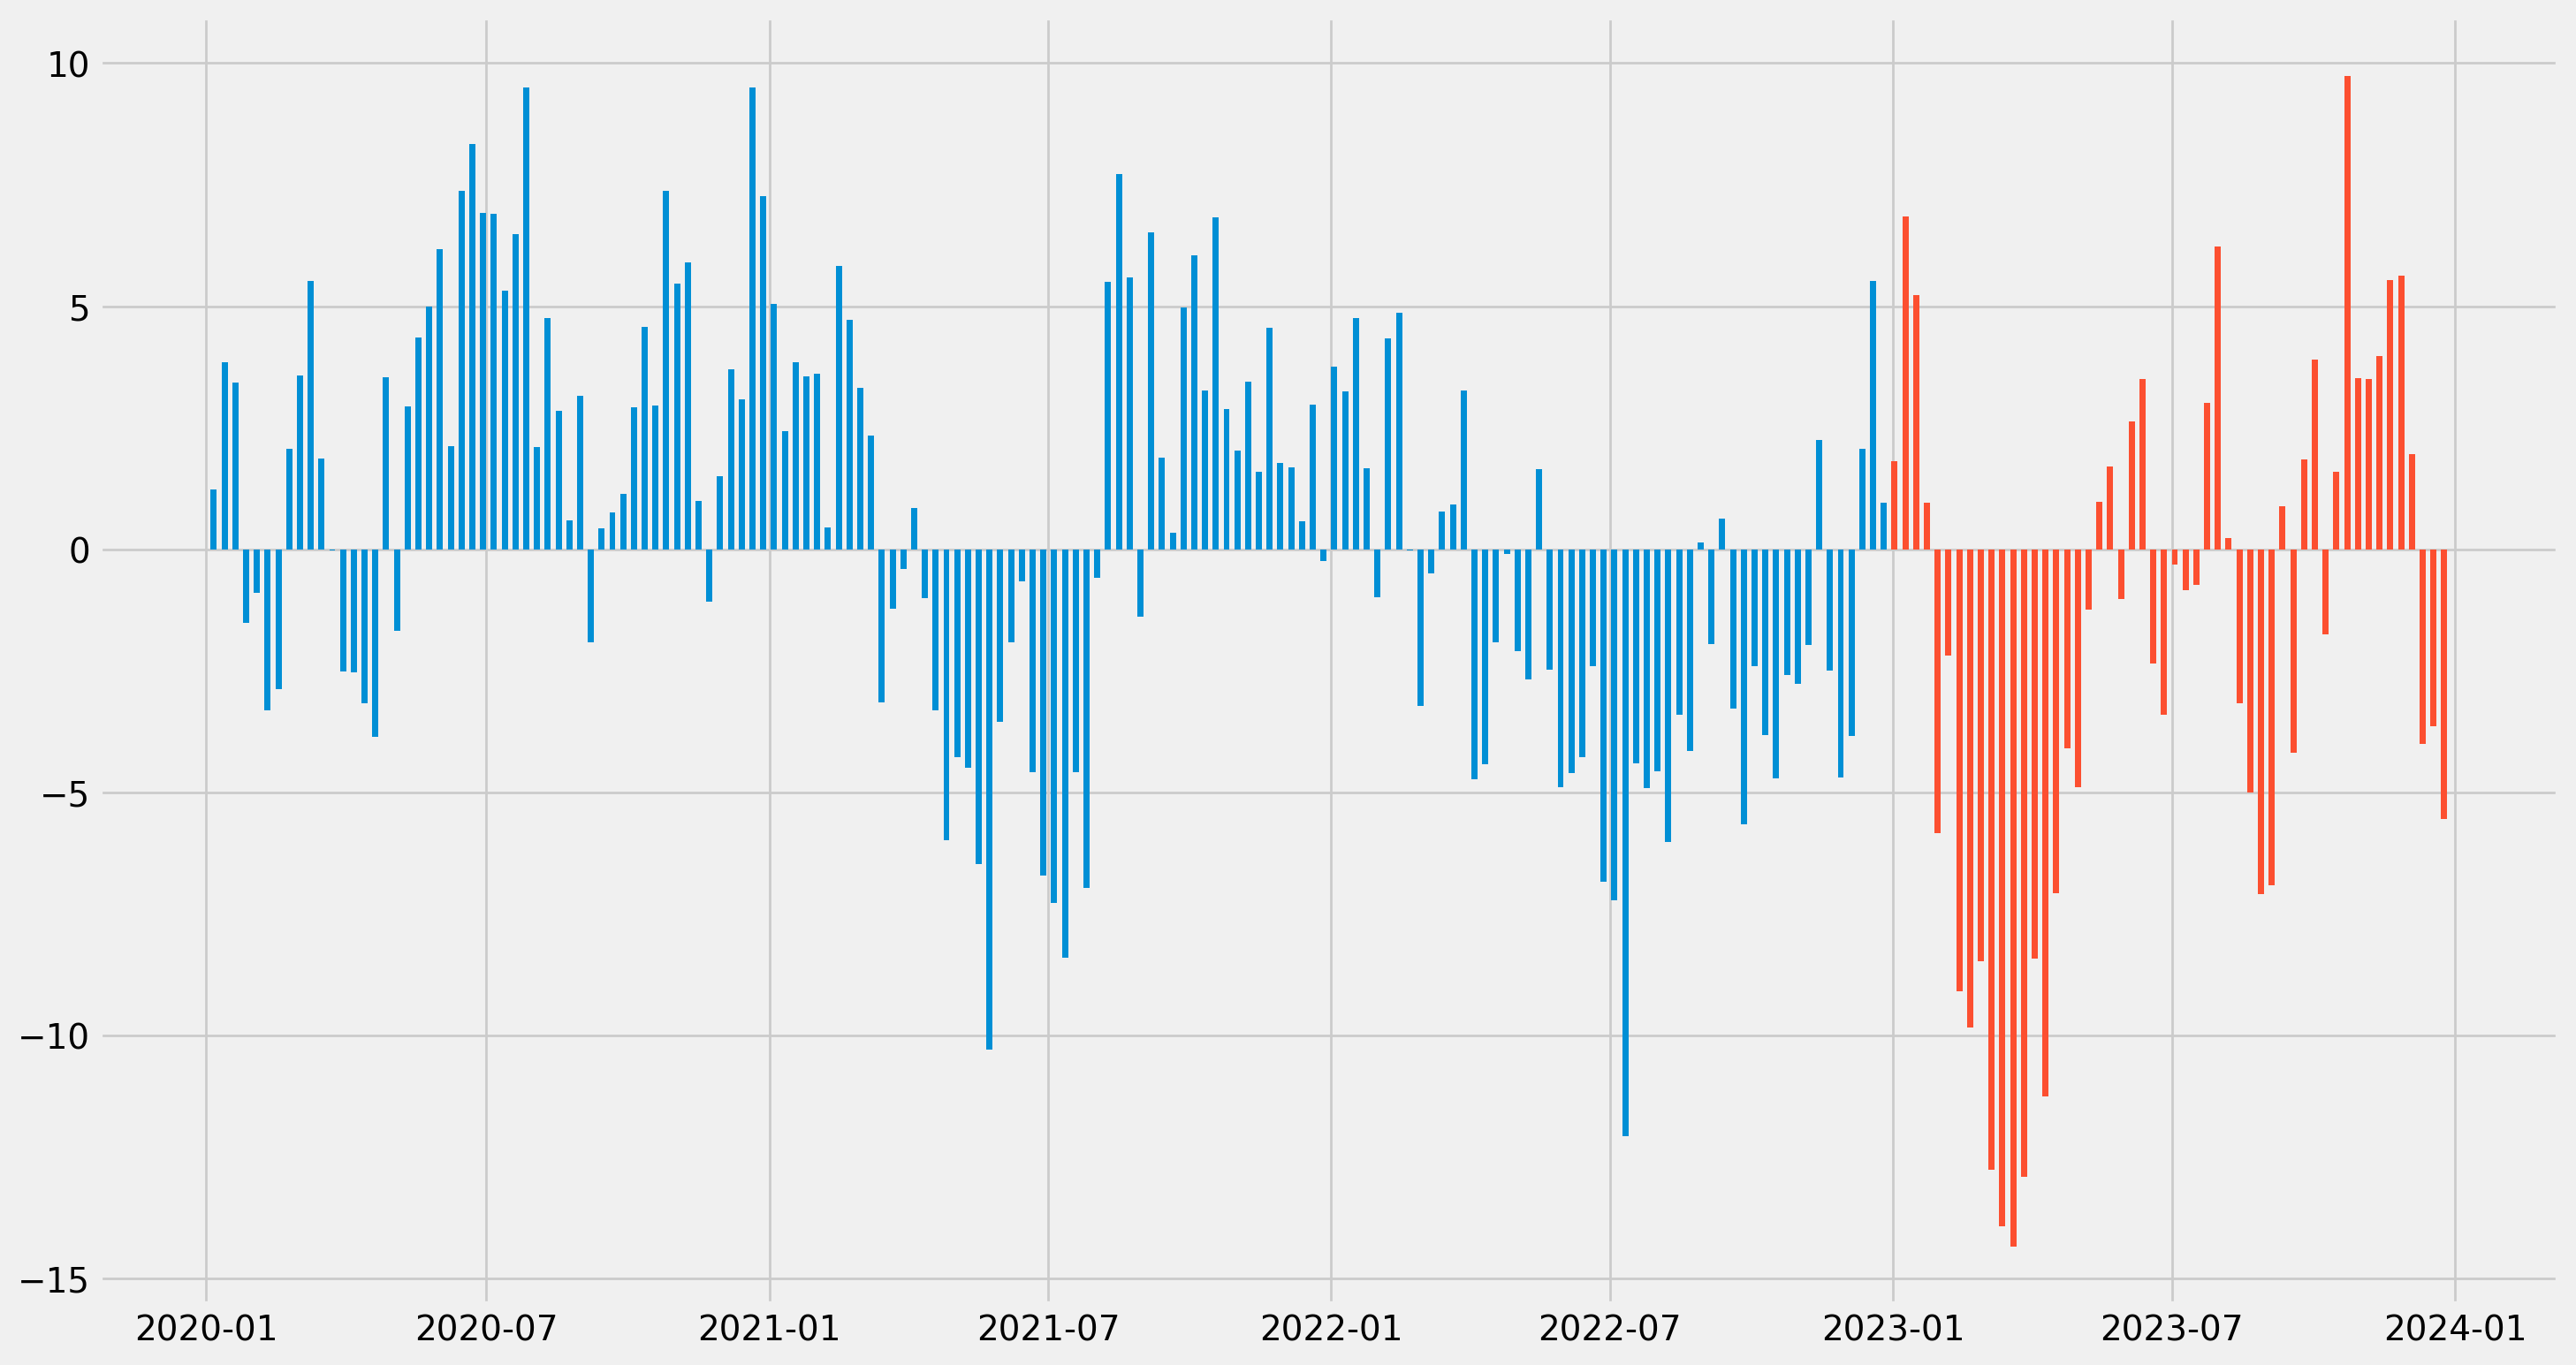

In [52]:
residuals_s = data['y'] - spurious_model_prediction['mean']
residuals = data['y'] - 2*((data['x_causal']))
plt.bar(data.index[:split_index], residuals_s[:split_index], 4, label='Residuals')
plt.bar(data.index[split_index:], residuals_s[split_index:], 4, label='OOS residuals')
plt.show()
plt.bar(data.index[:split_index], residuals[:split_index], 4, label='Residuals')
plt.bar(data.index[split_index:], residuals[split_index:], 4, label='OOS residuals')
plt.show()

In [53]:
pretty_adf(data['y']);

ADF Statistic: -0.930
p-value: 0.953
Fail to reject the null hypothesis, the data is non-stationary


In [54]:
pretty_kpss(data['y'], regression='ct');

KPSS Statistic: 0.421
p-value: 0.010
Reject the null hypothesis, the data is non-stationary


/Users/mreda/Desktop/Scratch/non-stationary data/utils/stats.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  crit, p, *_ = tsa.kpss(data, regression=regression)


In [55]:
crt, p = pretty_adf(data['x_causal'],regression='ct')

ADF Statistic: 0.019
p-value: 0.994
Fail to reject the null hypothesis, the data is non-stationary


In [56]:
crt, p = pretty_kpss(data['x_causal'], regression='ct');

KPSS Statistic: 0.414
p-value: 0.010
Reject the null hypothesis, the data is non-stationary


/Users/mreda/Desktop/Scratch/non-stationary data/utils/stats.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  crit, p, *_ = tsa.kpss(data, regression=regression)


In [57]:
pretty_coint(data['y'], data['x_causal']);

Critical value: -4.369, p-value: 0.002
Reject the null hypothesis, the data is cointegrated


In [58]:
vecm_model = tsa.VECM(train[['y', 'x_causal']], k_ar_diff=0, deterministic='n', freq='W-MON').fit()
vecm_model.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.3160,0.071,-4.423,0.000,-0.456,-0.176
,coef,std err,z,P>|z|,[0.025,0.975]
ec1,-0.0202,0.024,-0.833,0.405,-0.068,0.027
,coef,std err,z,P>|z|,[0.025,0.975]
beta.1,1.0000,0,0,0.000,1.000,1.000
beta.2,-1.9679,0.089,-22.213,0.000,-2.142,-1.794


In [59]:
vecm_model.test_granger_causality('y', 'x_causal').summary()

Test statistic,Critical value,p-value,df
10.75,3.873,0.001,"(1, 300)"


In [60]:
vecm_model.test_inst_causality('x_causal').summary()

Test statistic,Critical value,p-value,df
44.26,3.841,0.000,1


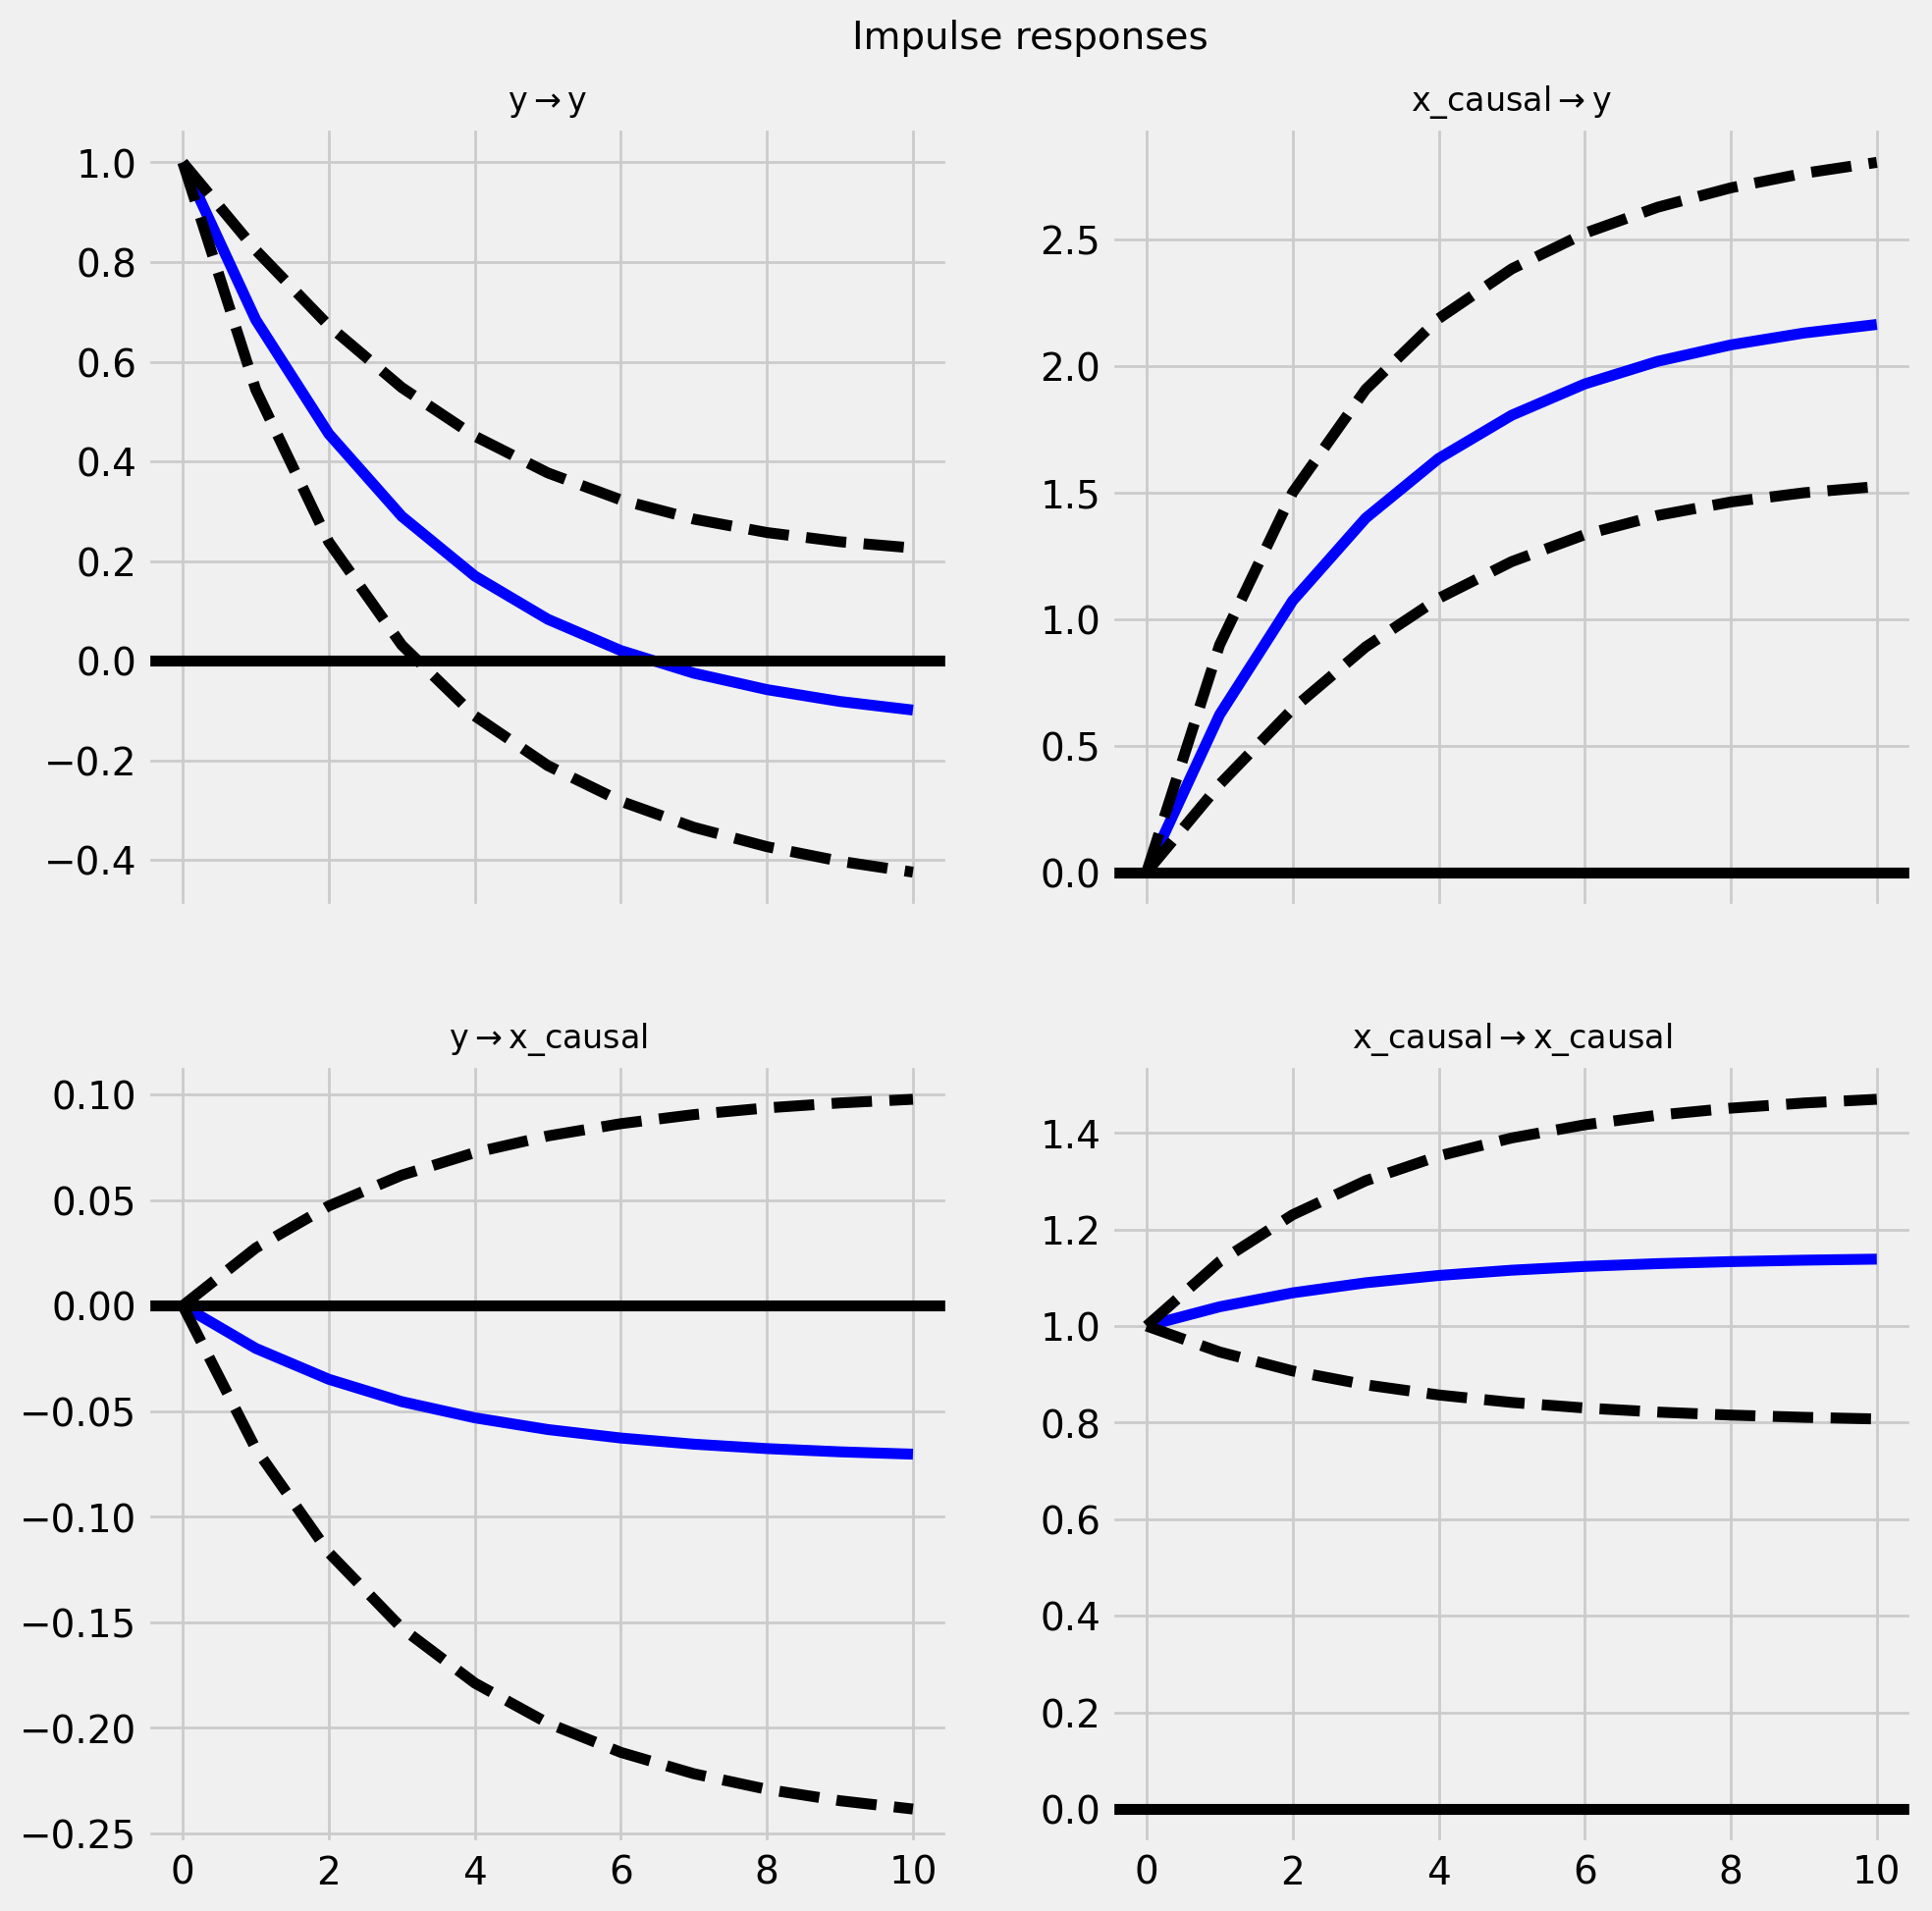

In [61]:
vecm_model.irf(10).plot();

<BarContainer object of 154 artists>

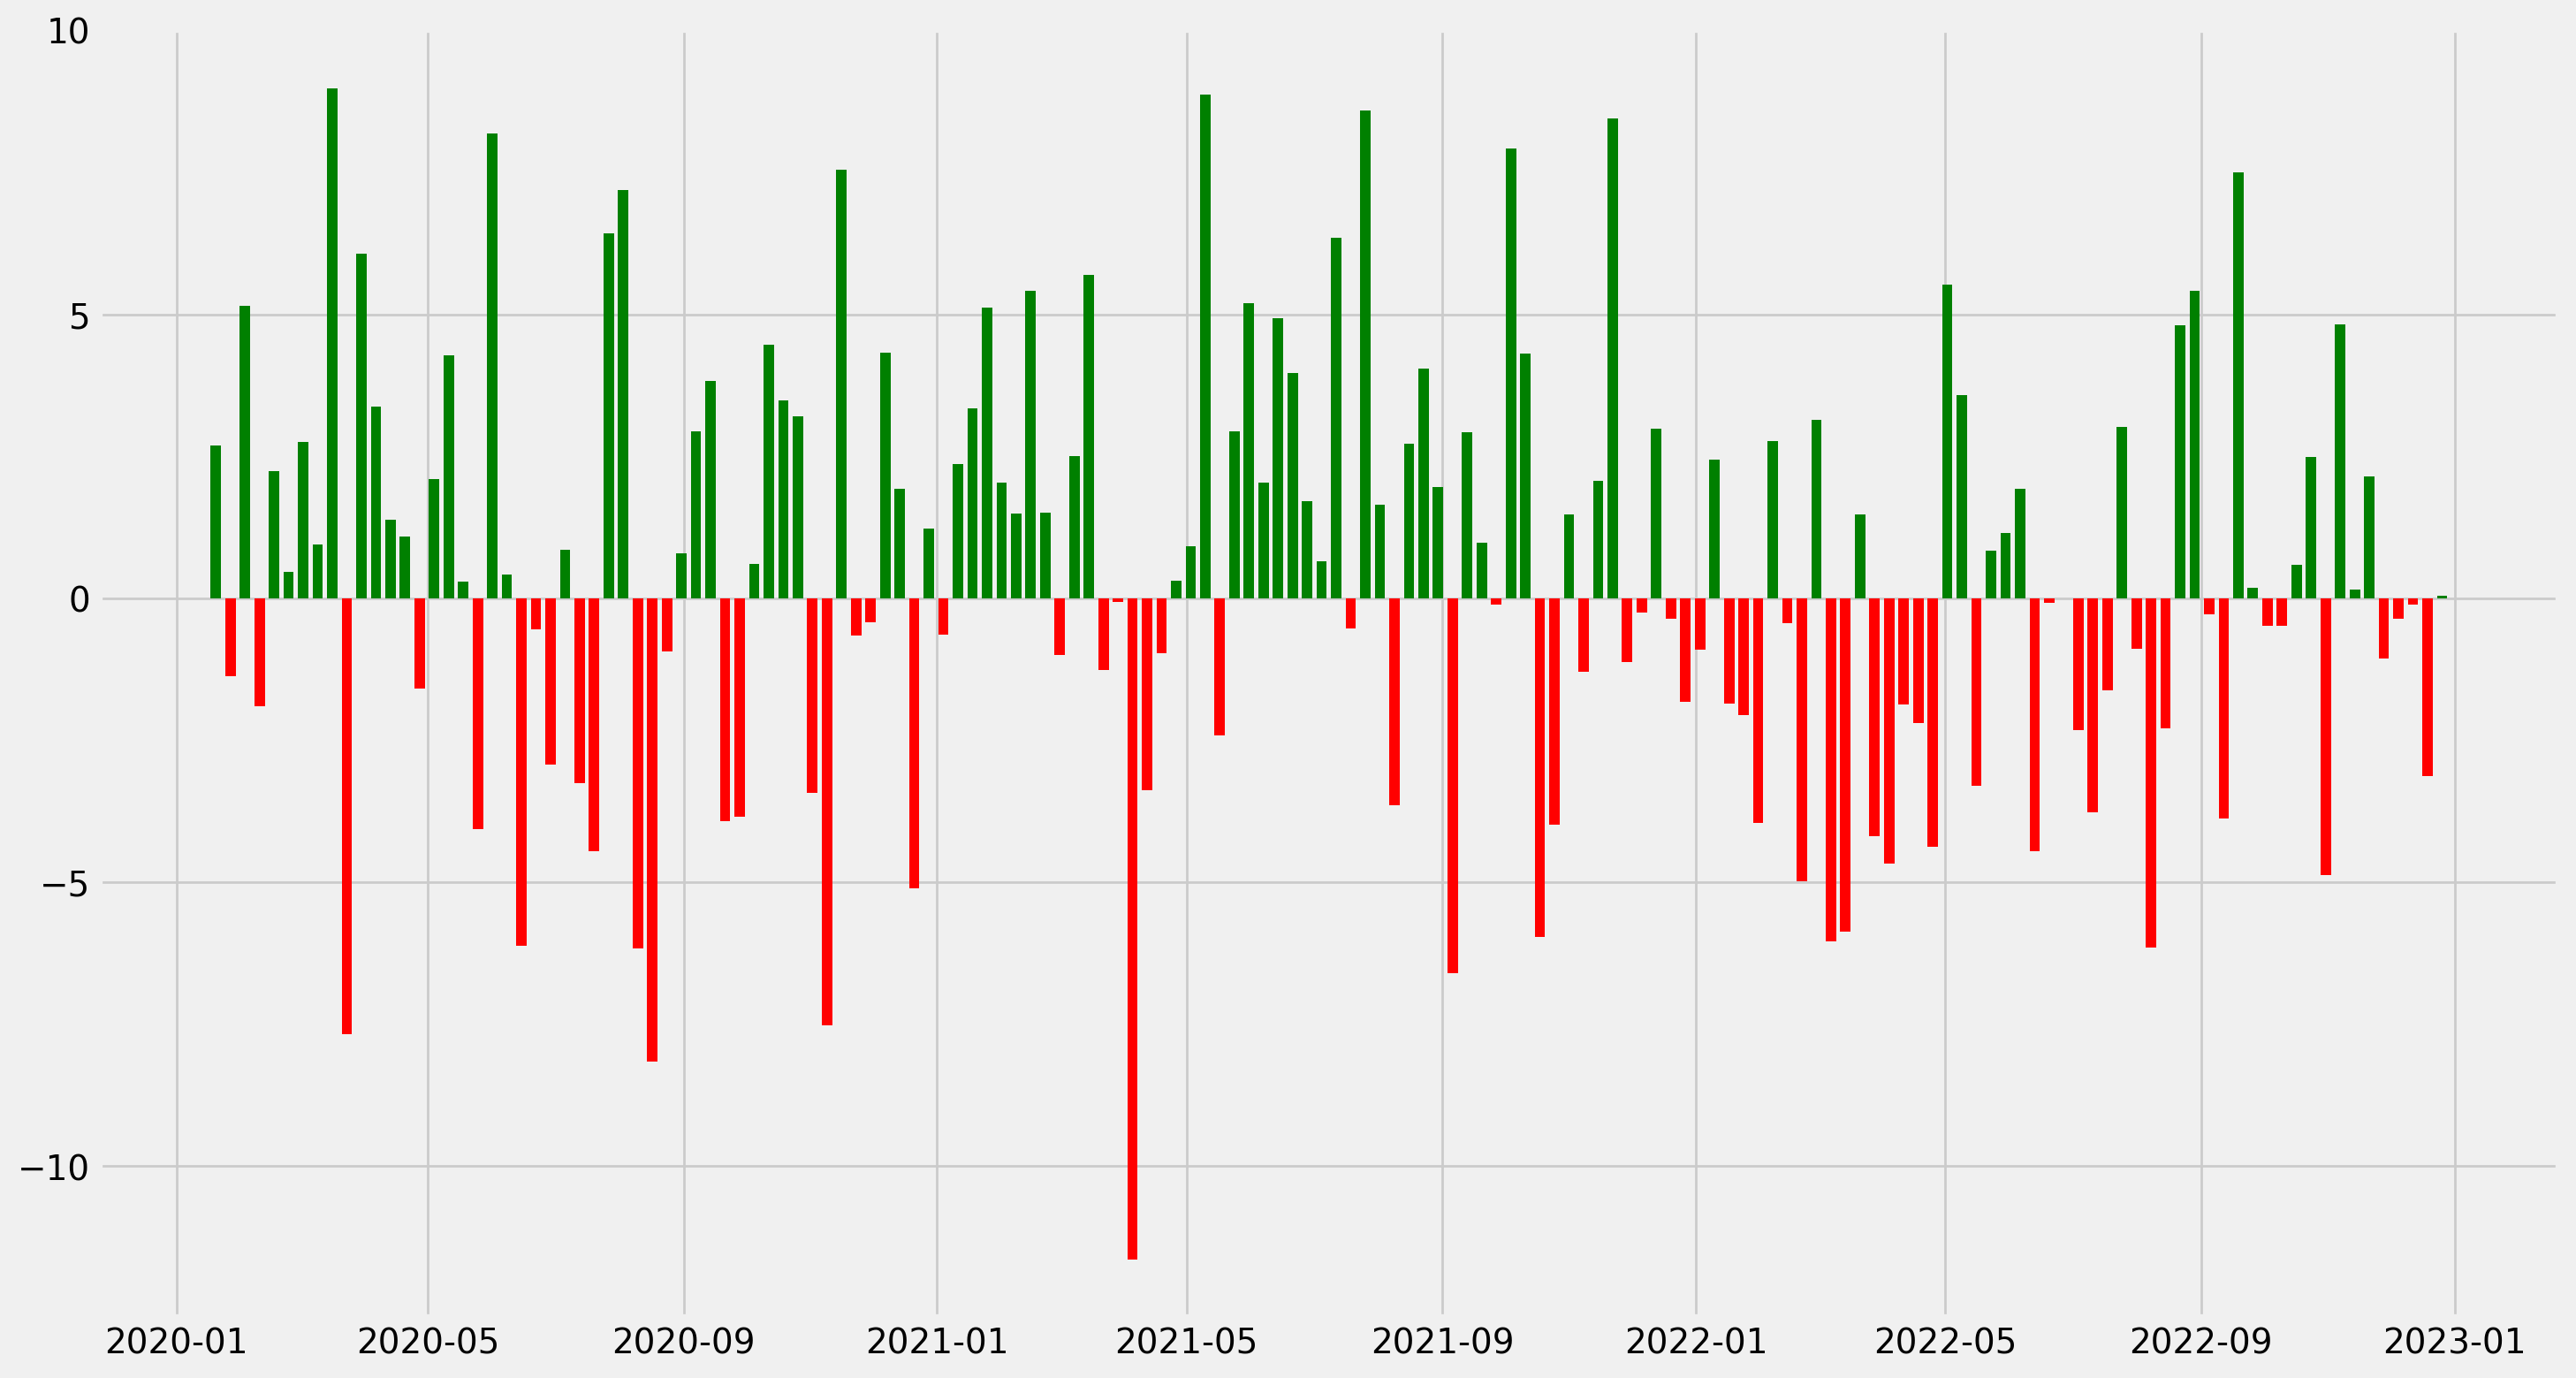

In [73]:
plt.bar(train.index[2:], vecm_model.resid[:, 0], 5, color=['g' if i > 0 else 'r' for i in vecm_model.resid[:, 0]], label='Residuals')

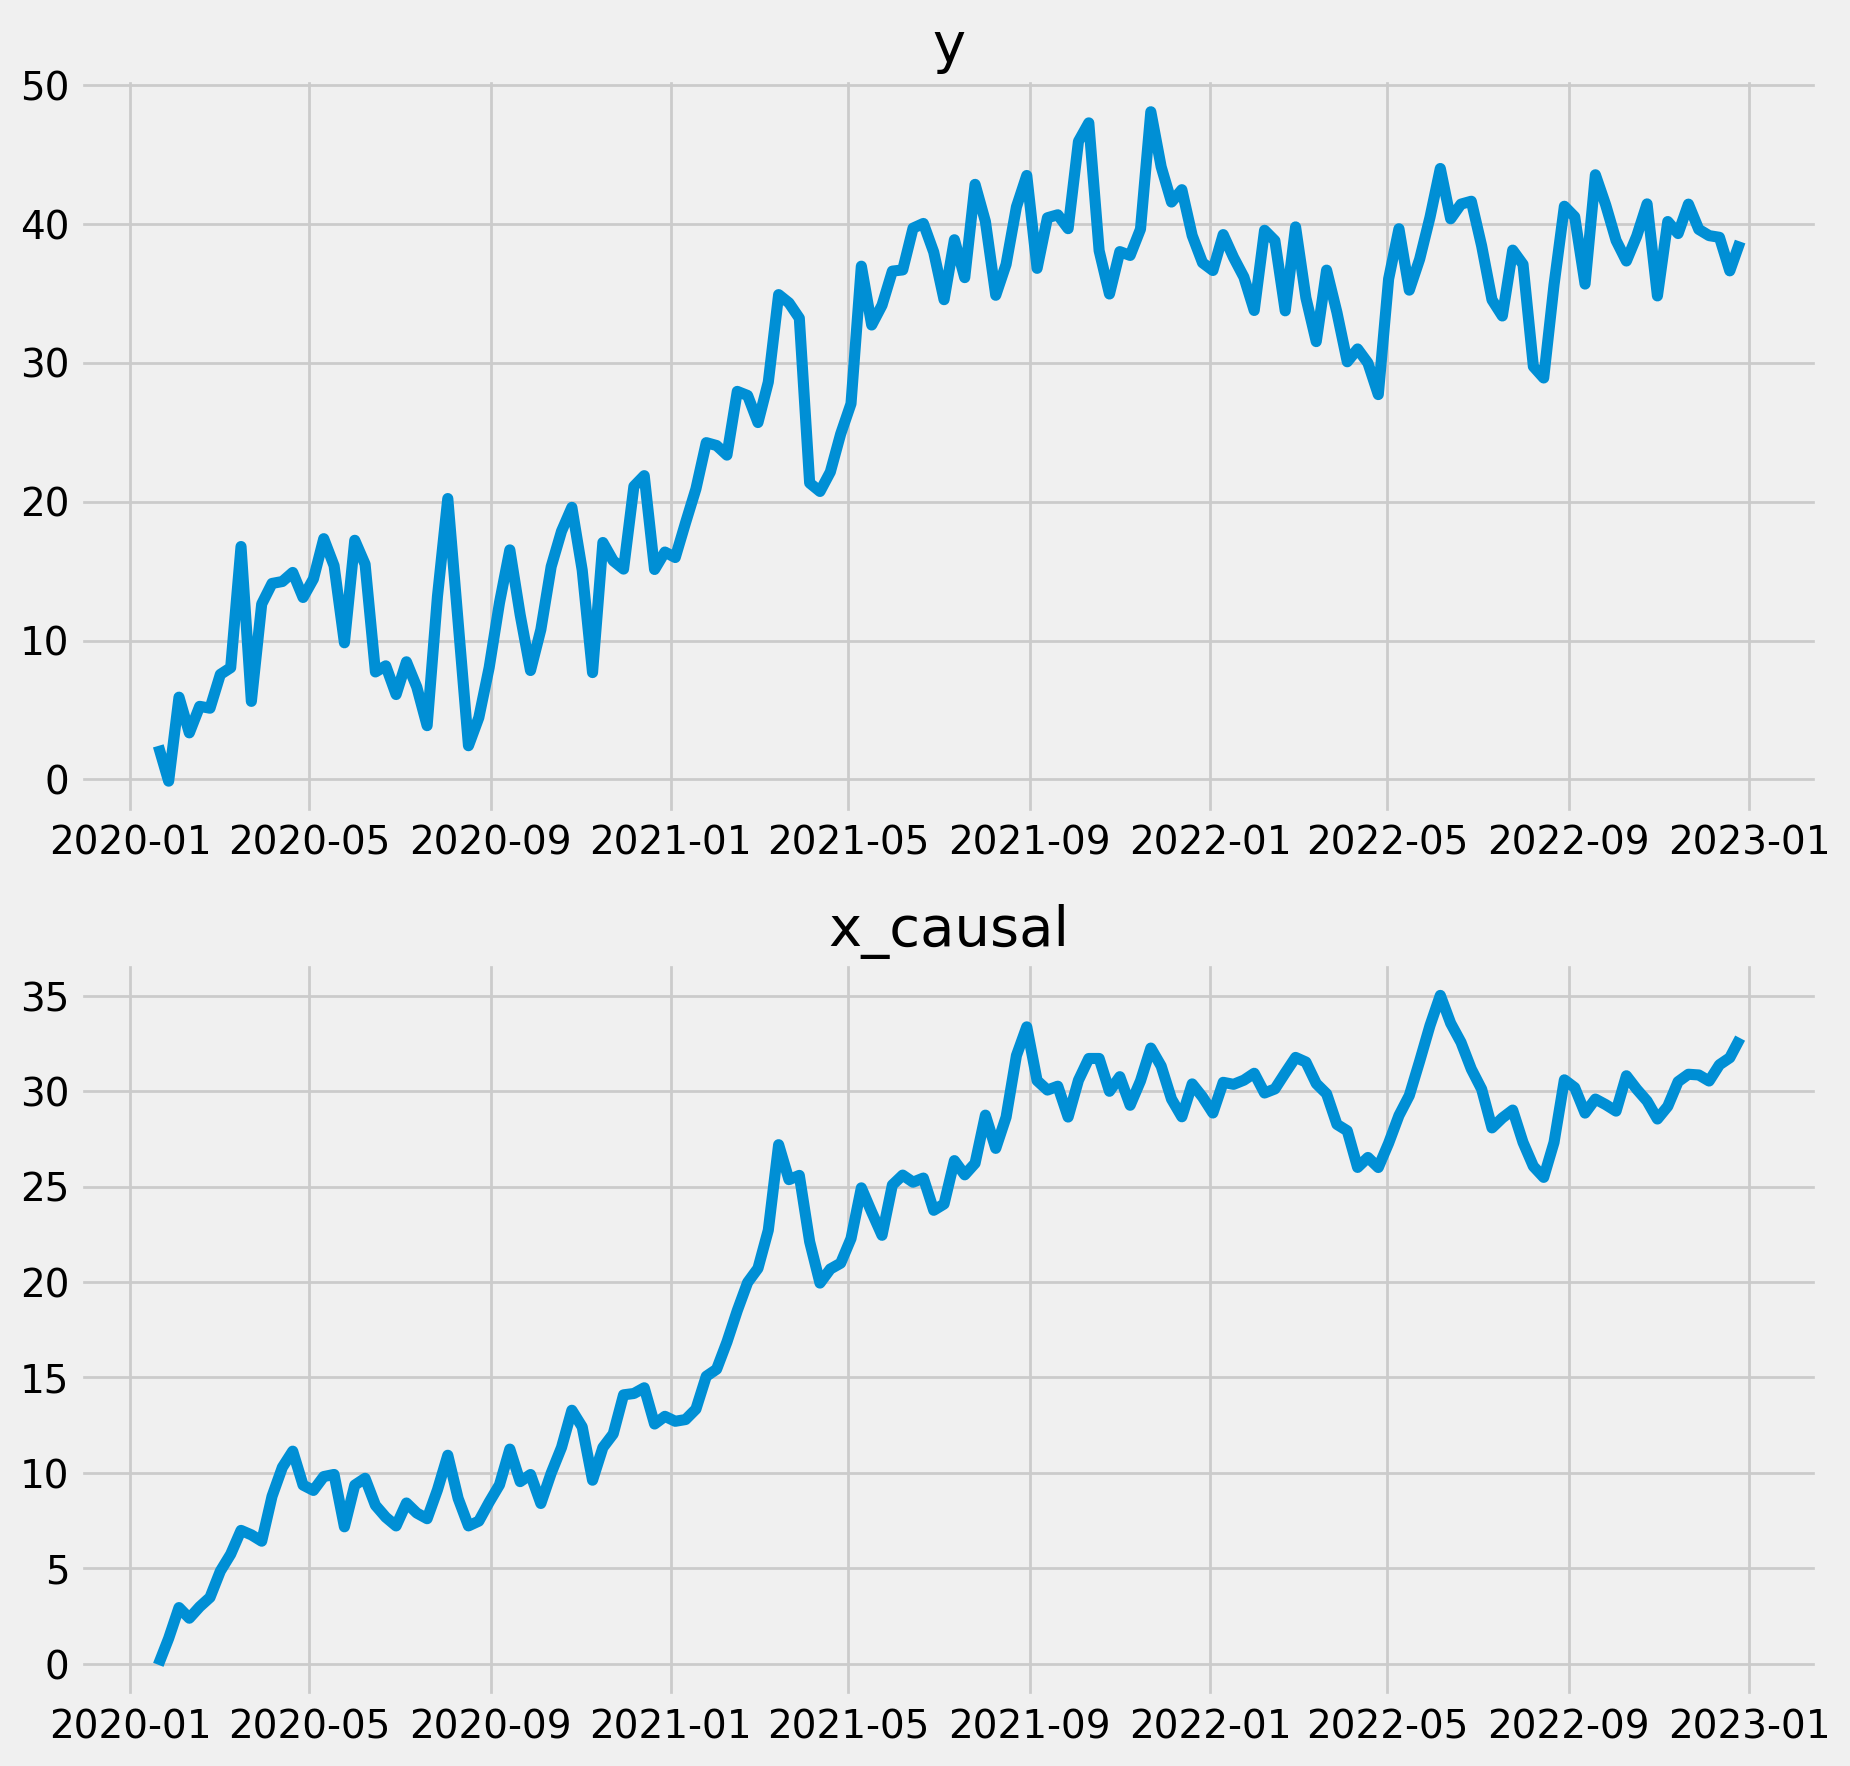

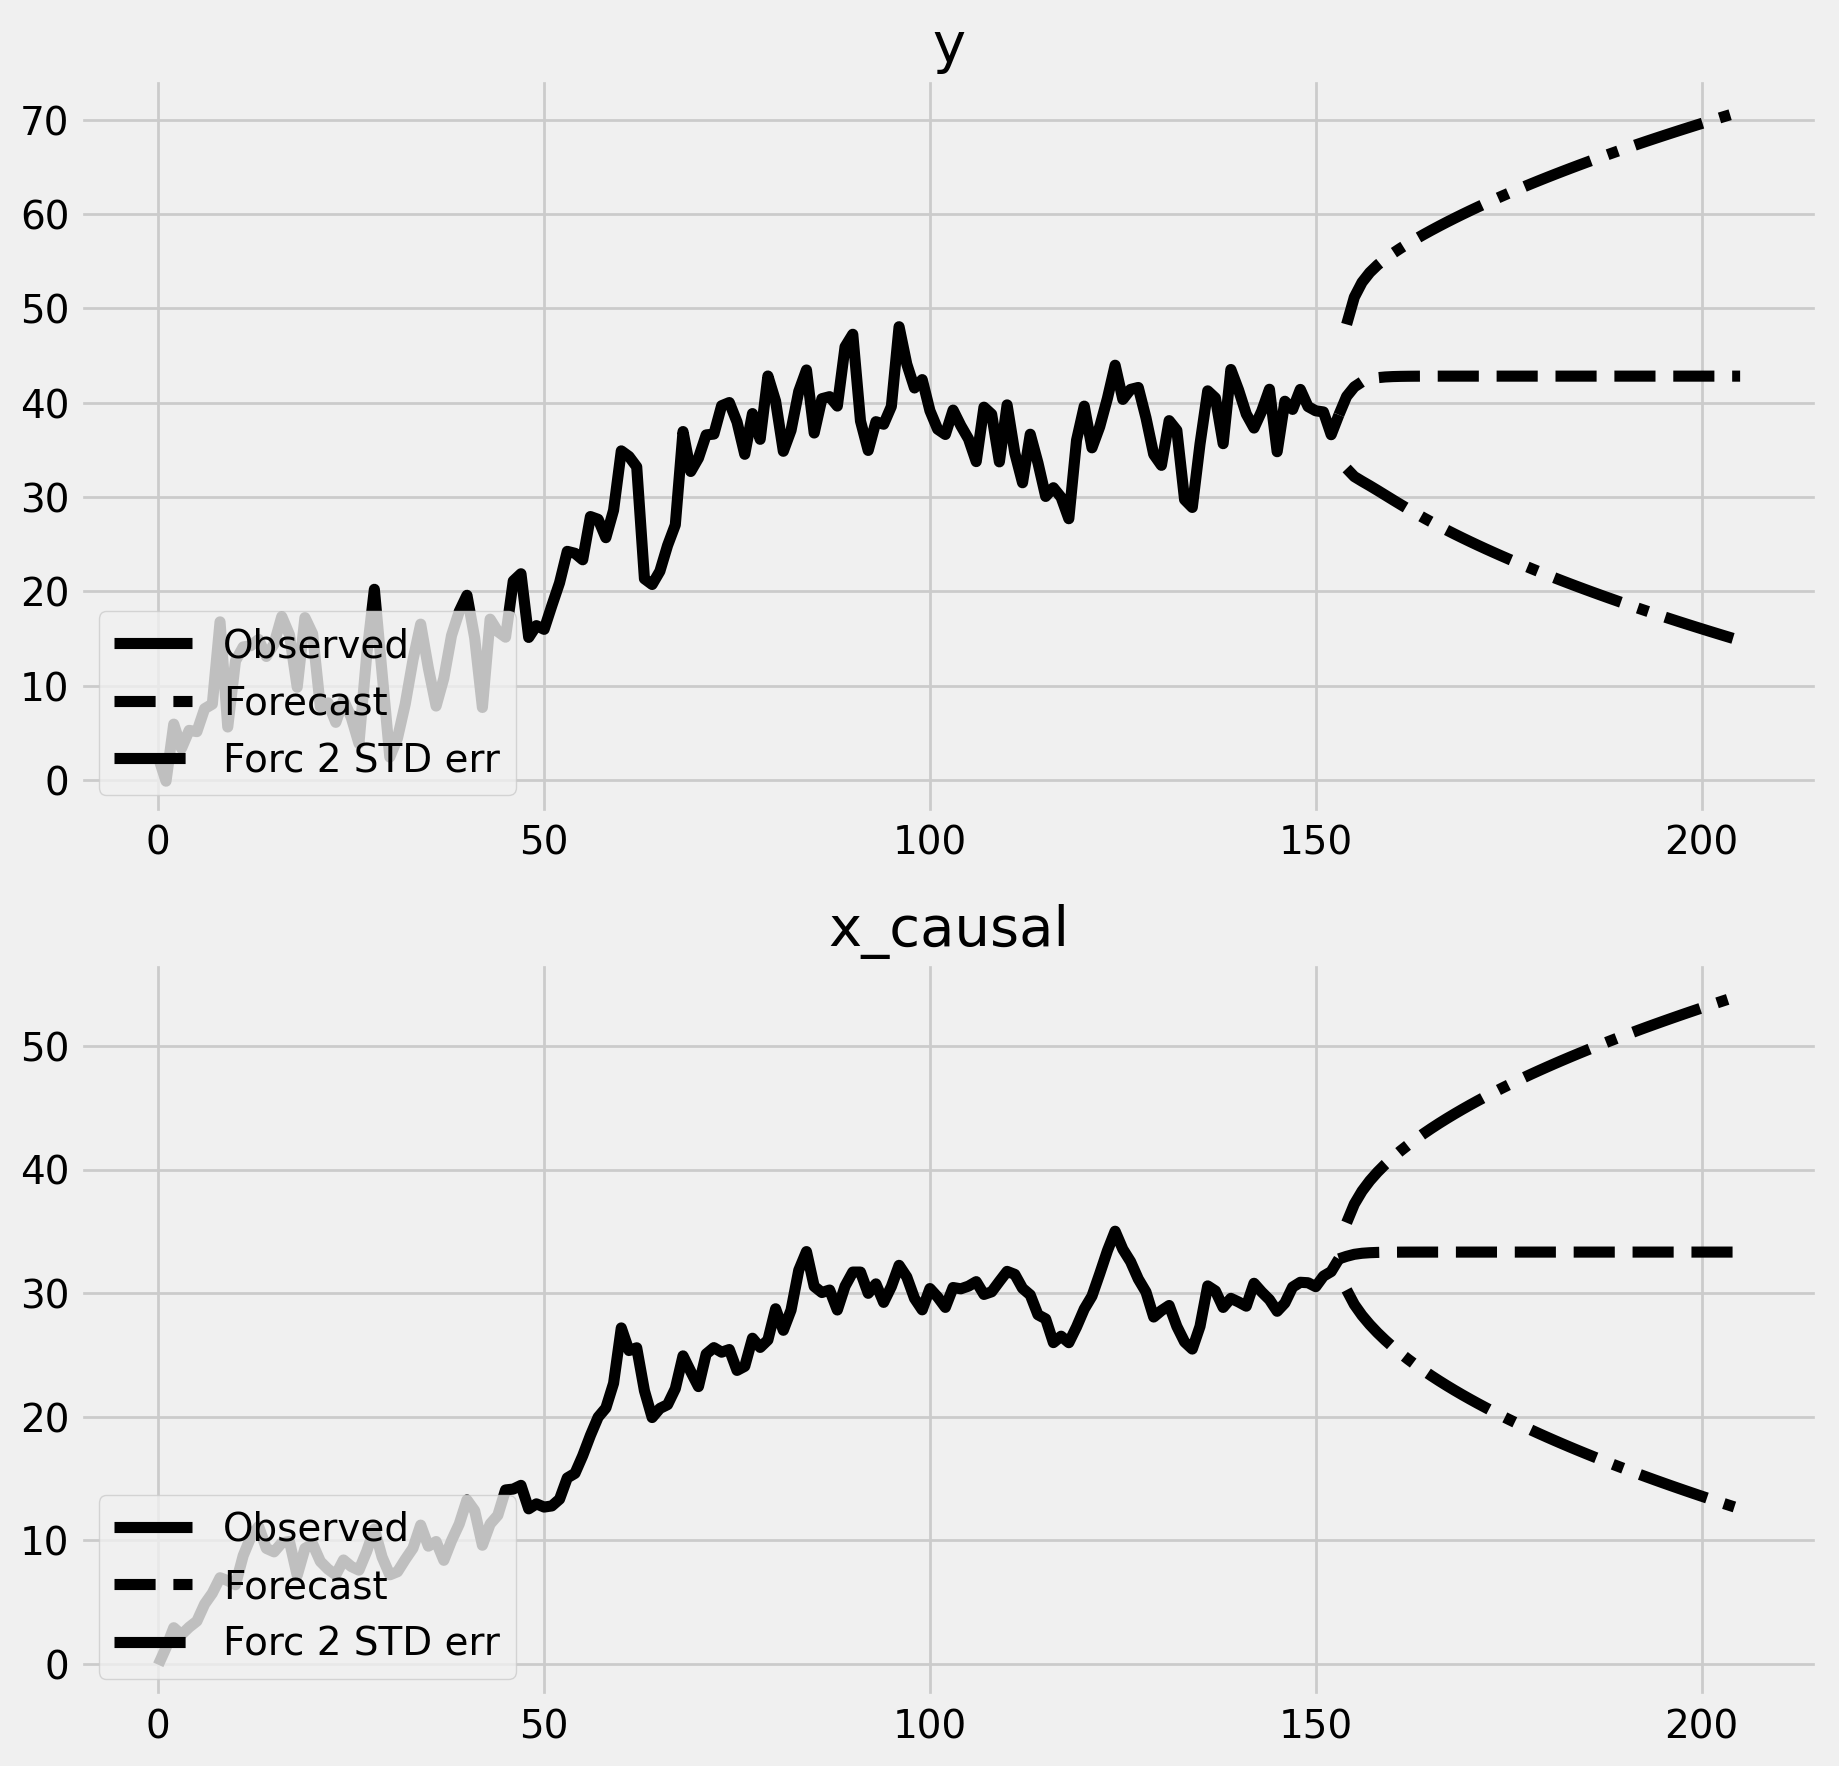

In [75]:
vecm_model.plot_data()
ax = vecm_model.plot_forecast(52)

In [76]:
ax.